**<h2>Computing Water Potential Energy Surface Using Behler and Parinello Symmetry Functions** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

Loading the data (energies and geometries) for 1000 water molecule configurations in .xyz form

In [2]:
energies = np.genfromtxt('./water/energies.txt')
print("Energies file has",np.shape(energies),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)

Energies file has (1000,) entries


In [3]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('water', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates = (xyz_file[:,1:-1])
coordinates = coordinates.astype(np.float)

#print(symbols)
#print(coordinates)

<ipython-input-3-c38e52de7b08>:5: ConversionWarning: Some errors were detected !
    Line #6 (got 1 columns instead of 5)
    Line #11 (got 1 columns instead of 5)
    Line #16 (got 1 columns instead of 5)
    Line #21 (got 1 columns instead of 5)
    Line #26 (got 1 columns instead of 5)
    Line #31 (got 1 columns instead of 5)
    Line #36 (got 1 columns instead of 5)
    Line #41 (got 1 columns instead of 5)
    Line #46 (got 1 columns instead of 5)
    Line #51 (got 1 columns instead of 5)
    Line #56 (got 1 columns instead of 5)
    Line #61 (got 1 columns instead of 5)
    Line #66 (got 1 columns instead of 5)
    Line #71 (got 1 columns instead of 5)
    Line #76 (got 1 columns instead of 5)
    Line #81 (got 1 columns instead of 5)
    Line #86 (got 1 columns instead of 5)
    Line #91 (got 1 columns instead of 5)
    Line #96 (got 1 columns instead of 5)
    Line #101 (got 1 columns instead of 5)
    Line #106 (got 1 columns instead of 5)
    Line #111 (got 1 columns instead

In [4]:
## Alternatively loading the data in .npy form
# # The data was downloaded from http://www.quantum-machine.org/datasets/ (Densities dataset--> water.zip)
# # The data includes energies, densities and structure for water molecules
# #For each dataset, structures are given in with positions in Bohr and the energies are given in kcal/mol 
# energy_data = np.load('./water_102/dft_energies.npy')
# print("Energies file has",np.shape(energy_data),"entries")
# geometry_data =  np.load('./water-2/water_102/structures.npy')
# print("Geometry file has",np.shape(geometry_data),"entries")
# print(type(energy_data))
# print(type(geometry_data))

In [31]:
print(np.shape(coordinates))
print(type(coordinates))
print(coordinates[0])
print(coordinates[1])
print(coordinates[2])

print('gfjkhgfjhgfkgh')
print(coordinates[3])
print(coordinates[4])
print(coordinates[5])

print(energies[0])
# There is 1000 water molecules and each of them consists of 3 atoms, so we have 3000 atoms in total and each
# of them has 3 coordinates.
# Thus the coordinates array has 3000 lines, each of them corresponding to one atom (the first three lines
# correspopnd to the first water molecule) and 3 columns corresponding to the x, y and z coordinates respectively.

(3000, 3)
<class 'numpy.ndarray'>
[0.         0.769767   0.55746937]
[ 0.         -0.71017975  0.50340914]
[ 0.         -0.0037242  -0.06630491]
gfjkhgfjhgfkgh
[0.         0.77715107 0.59586089]
[ 0.         -0.77642641  0.59515778]
[ 0.000000e+00 -4.529000e-05 -7.443867e-02]
-13815.2523726009


**<h2>Cutoff Function** 
    $$f_c(R_{ij}) = 
    \begin{cases}
        0.5 \times \big[\cos\big(\frac{\pi R_{ij}}{R_c}\big)+1\big]  & \text{for } R_{ij} \leq R_c\\
        0  & \text{for } R_{ij} > R_c
    \end{cases}
    $$
    
In the Behler and Parinello paper the Cutoff radius $R_c$ was taken to be $6$  Ångströms, or 11.3384 Bohr radii. (Remember, 1 Ångström is $10^{-10}$m)

In [6]:
def fc(R,Rc):
    if R <= Rc:
        fcutoff = 0.5 * (np.cos(np.pi*R/Rc)+1)
    else:
        fcutoff = 0
    return fcutoff

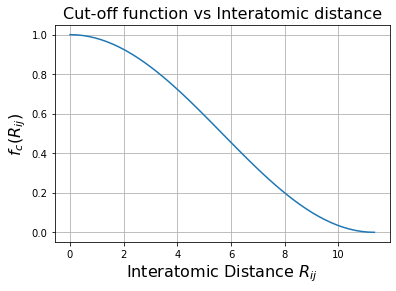

In [7]:
# Plotting fc as a function of interatomic distance Rij

Rc  = 11.3384 # Bohr

Rij     = np.linspace(0,Rc)
fcutoff = np.zeros(np.size(Rij))

for i in range(np.size(Rij)):
    fcutoff[i] = fc(Rij[i],Rc)

plt.plot(Rij,fcutoff)
plt.title('Cut-off function vs Interatomic distance', fontsize=16)
plt.xlabel('Interatomic Distance $R_{ij}$', fontsize=16)
plt.ylabel('$f_c(R_{ij})$', fontsize=16)
plt.grid()

**<h2>Pairwise Distances**

$$Dp = \begin{bmatrix} R_{00} & R_{01} & R_{02} \\ R_{10} & R_{11} & R_{12} \\ R_{20} & R_{21} & R_{22} \end{bmatrix} = \begin{bmatrix} 0 & R_{01} & R_{02} \\ R_{01} & 0 & R_{12} \\ R_{02} & R_{12} & 0 \end{bmatrix} $$

In [8]:
i = 0                                # i-th water molecule
coord = coordinates[3*i:3*(i+1),:]   # Let's take the coordinates of the ith water molecule in our dataset and compute
                                     # pairwise distances between all of its 3 atom

def pairwise_distances(coord):                       # we pass in the coordinates of the 3 atoms in the water molecule
    pairwise_dist_matrix = np.zeros(np.shape(coord))       # Initialise the matrix
    N = len(coord)
    for i in range(0,N-1):
#        print('i=',i)
        for j in range(i+1,N):
#            print(j)
#            pairwise_dist_matrix[i][j] = \
#            np.sqrt(  (coord[i][0] - coord[j][0] )**2 + (coord[i][1] - coord[j][1] )**2 +(coord[i][2] - coord[j][2] )**2   )
            pairwise_dist_matrix[i][j] =  np.sqrt(sum( (coord[i,:] - coord[j,:])**2 ))
            pairwise_dist_matrix[j][i] = pairwise_dist_matrix[i][j]

    return pairwise_dist_matrix

Dp = pairwise_distances(coord)
print(Dp)



[[0.         1.48093379 0.99367147]
 [1.48093379 0.         0.9075536 ]
 [0.99367147 0.9075536  0.        ]]


**<h2>From Cartesian to Generalised Coordinates**

**<h3>Radial Symmetry Functions**
    
<h3>$$G_i^1 = \sum_{j \neq i}^{\text{all}} e^{-\eta (R_{ij}-R_s)^2} f_c (R_{ij})$$

In [9]:
heta = 0.1
Rs   = 0
N    = len(coord)


def radial_BP_symm_func(Dp,N,heta,Rs):
    G_mu1 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)
    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(0,i):
            G_mu1[i] = G_mu1[i] + np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
        for j in range(i+1,N):
            G_mu1[i] = G_mu1[i] +  np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
    return G_mu1

Gmu1 = radial_BP_symm_func(Dp,N,heta,Rs)
print(Gmu1)

[1.65865495 1.67618952 1.79537284]


**<h3> Angular Symmetry Functions**

$$G_i^2 = 2^{1-\zeta} \sum_{j,k \neq i}^{\text{all}} (1+\lambda \cos \theta_{ijk})^\zeta \times e^{-\eta (R_{ij}^2+R_{ik}^2+R_{jk}^2 )} f_c (R_{ij})f_c (R_{ik})f_c (R_{jk})$$
    
with parameters $\lambda = +1, -1$, $\eta$ and $\zeta$

In [10]:
lambdaa = 1     #1
zeta    = 0.2
heta    = 0.1

N = len(coord)

def angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta):
    G_mu2 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)

    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(N):           
            for k in range(N):
                if j != i and k !=i:
                    R_vec_ij = coord[i,:] - coord[j,:]
                    R_vec_jk = coord[k,:] - coord[k,:]
                    theta_ijk  = np.dot(R_vec_ij, R_vec_jk)/(Dp[i][j]*Dp[i][k])
                    G_mu2[i]   = G_mu2[i] + (  1 + lambdaa * np.cos(theta_ijk) )**zeta  \
                                * np.exp( -heta * (Dp[i][j]**2 + Dp[i][k]**2 + Dp[j][k]**2) ) \
                                * fc(Dp[i][j],Rc) * fc(Dp[i][k],Rc) * fc(Dp[j][k],Rc)            
        G_mu2[i]   = 2**(1-zeta) * G_mu2[i] 
    return G_mu2

Gmu2 = angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta)
print(Gmu2)

[5.24624271 5.30920488 5.70457288]


**<h2>Training and Test Set**

In [11]:
a = np.ones(4)
print(a)

[1. 1. 1. 1.]


In [12]:
N                    = 3           # number of atoms per molecule
number_of_features   = 48           # number of features (symmetry functions) for each atom (we create one radial)
                                   # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.

heta   = np.linspace(0.01, 0.5, num=number_of_features)
random.shuffle(heta)

Rs     = np.linspace(0, 1, num=number_of_features)
random.shuffle(Rs)

lambdaa = np.ones(number_of_features)
random.shuffle(lambdaa)

zeta    = np.linspace(0, 0.5, num=number_of_features)
random.shuffle(zeta)


data_size            = 1000        # We have 1000 water molecule conformations
training_set_size    = 900



    
G = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features,2):
        G[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j])     
        G[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
# Computing variance and mean on the training data only!
G_train = G[:training_set_size,:]
var  = np.var(G_train,axis=0)
mean = np.mean(G_train,axis=0)

# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G)[0]):
    for j in range(np.shape(G)[1]):
        G[i,j] = (G[i,j]-mean[j])/var[j]   


data_set = np.vsplit(G,1000)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set = torch.FloatTensor(data_set)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

# print(data_set[0])
# print(data_set[0][1][1])
labels = torch.FloatTensor(energies)            # turning energies into a (1000) tensor

# Splitting the dataset into training and test set
training_set         = data_set[:training_set_size]
test_set             = data_set[training_set_size:]

train_labels         = labels[:training_set_size]
test_labels          = labels[training_set_size:]

# Dataset
dataset = TensorDataset(training_set, train_labels)
#print(dataset[0])

# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                           shuffle=False, num_workers=2, drop_last=False) # ?????

print(np.shape(training_set))

torch.Size([900, 3, 48])


In [13]:
print(G)

[[-3.46137902e+00 -1.14212086e+00 -4.12715976e+00 ... -8.42847222e-01
  -8.88665804e+00 -6.82931635e-01]
 [-1.85996387e+00 -1.85486618e-01 -2.40254041e+00 ... -1.20897198e-01
  -5.15934437e+00  4.02383263e-04]
 [ 9.08780182e+00  3.77366676e+00  1.15564586e+01 ...  3.38887085e+00
   2.58829181e+01  4.26976559e+00]
 ...
 [-6.97836290e+00 -3.33269582e+00 -8.83353542e+00 ... -2.99983690e+00
  -1.98211045e+01 -3.79562175e+00]
 [-5.43829439e+00 -2.52118984e+00 -7.09578537e+00 ... -2.36470573e+00
  -1.60826588e+01 -3.16158677e+00]
 [ 6.46182092e+00  1.23270669e+00  8.66365697e+00 ...  1.13484113e+00
   1.96436158e+01  1.44045170e+00]]


In [14]:
a = np.array([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
# for i in range(3):
#     a[i,0] = a[i,0]/(sum(a[:,0])/3)
# print(a)

b = (sum(a[:,0])/3)
print(b)
print(type(b))
a[0,0] = a[0,0]/b
print(a)

3.0
<class 'numpy.float64'>
[[0.33333333 2.        ]
 [3.         4.        ]
 [5.         6.        ]]


**<h2>Building Neural Network Architecture**

In [56]:
class Subnets(nn.Module):
    def __init__(self):
        super(Subnets, self).__init__()
        self.fc1 = nn.Linear(48, 40)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(40, 40)        
        self.fc3 = nn.Linear(40, 1)
#         self.fc4 = nn.Linear(10, 8)
#         self.fc5 = nn.Linear(8, 6)
#         self.fc6 = nn.Linear(6, 4)
#         self.fc7 = nn.Linear(4, 2)
#         self.fc8 = nn.Linear(2, 1)


    def forward(self, x):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
#         x = torch.tanh(self.fc3(x))
#         x = torch.tanh(self.fc4(x))
#         x = torch.tanh(self.fc5(x))
#         x = torch.tanh(self.fc6(x))
#         x = torch.tanh(self.fc7(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.network1 = Subnets()
        self.network2 = Subnets()
        self.network3 = Subnets()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
#         print(x1)
#         print(x2)
#         print(x3)
        
        x = torch.cat((x1, x2, x3), 0)
#        x = torch.sum(x)                      #??????????????????????????? try average pooling?
#        x = torch.reshape(x,[1])
        return x

    
model = BPNN()
N = 1
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)


# print(model)

# print('Network1')

# print('layer 1')
# print('weights')
# print(model.network1.fc1.weight)
# print('biases')
# print(model.network1.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network1.fc2.weight)
# print('biases')
# print(model.network1.fc2.bias)

# print('Network2')

# print('layer 1')
# print('weights')
# print(model.network2.fc1.weight)
# print('biases')
# print(model.network2.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network2.fc2.weight)
# print('biases')
# print(model.network2.fc2.bias)

# print('Network3')

# print('layer 1')
# print('weights')
# print(model.network3.fc1.weight)
# print('biases')
# print(model.network3.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network3.fc2.weight)
# print('biases')
# print(model.network3.fc2.bias)



x1 tensor([ -3.4614,  -1.1421,  -4.1272,  -0.9010,  -3.3397,  -1.2593,  -6.4893,
         -0.6852,  -8.1567,  -0.6702,  -3.8836,  -0.9218,  -6.9914,  -0.6715,
         -4.6345,  -0.8079,  -4.0299,  -0.8808,  -3.7223,  -1.3225,  -3.4429,
         -1.1703, -10.1873,  -0.7112,  -9.2319,  -0.6742,  -9.9148,  -0.6944,
         -6.5830,  -0.6928,  -4.4351,  -0.9887,  -6.8598,  -0.6789,  -5.2835,
         -0.7016,  -3.8010,  -0.9434, -30.1964,  -1.4100,  -4.3126,  -1.0880,
         -4.3955,  -0.7760,  -5.5214,  -0.8428,  -8.8867,  -0.6829])
x2 tensor([-1.8600e+00, -1.8549e-01, -2.4025e+00, -1.3626e-01, -1.7482e+00,
        -2.0403e-01, -3.9063e+00, -5.4006e-02, -5.0280e+00, -2.6118e-02,
        -2.1028e+00, -1.4133e-01, -3.8238e+00, -1.8026e-02, -2.7343e+00,
        -1.1048e-01, -1.9750e+00, -1.3117e-01, -3.8859e+00, -2.1293e-01,
        -1.7824e+00, -1.9020e-01, -5.8643e+00,  2.3480e-02, -7.5679e+00,
        -4.0777e-02, -5.8611e+00,  1.1190e-02, -4.1360e+00, -6.0240e-02,
        -3.2113e+00

In [59]:
x1, x2, x3 = training_set[0] + 10000000000
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)

x1 tensor([1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10])
x2 tensor([1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10,
        1.0000e+10, 1.0000e+10, 1

In [55]:
# w11 = model.network1.fc1.weight
# b11 = model.network1.fc1.bias
# print(np.shape(w11))
# x1 = np.reshape(x1,(2,1))
# x1 = np.array(x1)
# print(np.shape(x1))

# w11 = w11.cpu().detach().numpy()
# b11 = b11.cpu().detach().numpy()
# #b11 = np.transpose(b11)
# b11 = np.reshape(b11,(3,1))
# print(np.shape(b11))
# print(type(x1))
# print(type(w11))

# a11 = np.matmul(w11,x1) + b11
# a11 = np.tanh(a11)
# print(a11)
# #print(torch.tensordot(w11,x1))


In [53]:
print('layer 1')
print('weights')
print(model.network1.fc1.weight)
print('biases')
print(model.network1.fc1.bias)

print('layer 2')
print('weights')
print(model.network1.fc2.weight)
print('biases')
print(model.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.0578,  0.0214, -0.1110,  ..., -0.0372, -0.1181,  0.0973],
        [ 0.0336,  0.1225, -0.1007,  ...,  0.0593, -0.0575, -0.1059],
        [-0.0598, -0.0790, -0.0091,  ..., -0.0849, -0.1271, -0.0605],
        ...,
        [-0.0524, -0.1108, -0.1017,  ..., -0.0303,  0.0547,  0.0916],
        [-0.0279,  0.1061, -0.0474,  ...,  0.1050, -0.1314,  0.1326],
        [-0.0972,  0.0955, -0.0314,  ..., -0.0683, -0.1176, -0.0466]],
       requires_grad=True)
biases
Parameter containing:
tensor([ 0.0920, -0.0496, -0.1435, -0.0142,  0.1050,  0.0414, -0.0187, -0.1367,
         0.0514, -0.0667,  0.1149, -0.0905,  0.1327,  0.0898,  0.0112, -0.0590,
         0.0977, -0.1397,  0.0274,  0.0086,  0.0477, -0.0878,  0.0665,  0.0687,
        -0.0874,  0.1083,  0.0039, -0.0017,  0.1355, -0.0240, -0.0066,  0.0640,
         0.0901,  0.0006, -0.0004, -0.1057, -0.1009,  0.0728,  0.0754, -0.0741],
       requires_grad=True)
layer 2
weights
Parameter containing:
tensor

**<h2>Training the Neural Network**

In [18]:
net = BPNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 20


train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)


train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#        inputs = torch.reshape(inputs,(3,2))    #  hard-coded !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        # zero the parameter gradients
        optimizer.zero_grad()

#         print(np.shape(inputs))
#         print(inputs)
        
        # forward + backward + optimize

        outputs = net(inputs[0][0],inputs[0][1],inputs[0][2])        #??????????????????????????????????????
        
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss))
        running_loss = 0.0    

print('Finished Training')

[1,     1] loss: 190867232.000
[1,     2] loss: 190762304.000
[1,     3] loss: 190649136.000
[1,     4] loss: 190630368.000
[1,     5] loss: 190626720.000
[1,     6] loss: 190579312.000
[1,     7] loss: 190477984.000
[1,     8] loss: 190400240.000
[1,     9] loss: 190414672.000
[1,    10] loss: 190415120.000
[1,    11] loss: 190354736.000
[1,    12] loss: 190291408.000
[1,    13] loss: 190229696.000
[1,    14] loss: 190080272.000
[1,    15] loss: 190132432.000
[1,    16] loss: 190112416.000
[1,    17] loss: 190194832.000
[1,    18] loss: 190146352.000
[1,    19] loss: 190055008.000
[1,    20] loss: 189884096.000
[1,    21] loss: 190060128.000
[1,    22] loss: 191079088.000
[1,    23] loss: 189898896.000
[1,    24] loss: 189863344.000
[1,    25] loss: 190483968.000
[1,    26] loss: 189859248.000
[1,    27] loss: 190956560.000
[1,    28] loss: 189790416.000
[1,    29] loss: 189740272.000
[1,    30] loss: 189772304.000
[1,    31] loss: 189715280.000
[1,    32] loss: 189677808.000
[1,    3

[1,   275] loss: 181585280.000
[1,   276] loss: 181449584.000
[1,   277] loss: 181428480.000
[1,   278] loss: 181288192.000
[1,   279] loss: 181485632.000
[1,   280] loss: 181452000.000
[1,   281] loss: 181513248.000
[1,   282] loss: 181467056.000
[1,   283] loss: 181444320.000
[1,   284] loss: 181338000.000
[1,   285] loss: 181333504.000
[1,   286] loss: 181272960.000
[1,   287] loss: 181259360.000
[1,   288] loss: 181244432.000
[1,   289] loss: 181218240.000
[1,   290] loss: 181092080.000
[1,   291] loss: 180909168.000
[1,   292] loss: 181073872.000
[1,   293] loss: 181113712.000
[1,   294] loss: 181037680.000
[1,   295] loss: 181001392.000
[1,   296] loss: 180921968.000
[1,   297] loss: 180936544.000
[1,   298] loss: 180814304.000
[1,   299] loss: 180797888.000
[1,   300] loss: 180810144.000
[1,   301] loss: 180775744.000
[1,   302] loss: 180762560.000
[1,   303] loss: 180499520.000
[1,   304] loss: 180575072.000
[1,   305] loss: 180703456.000
[1,   306] loss: 180599088.000
[1,   30

[1,   565] loss: 172323792.000
[1,   566] loss: 172266064.000
[1,   567] loss: 172132320.000
[1,   568] loss: 171880656.000
[1,   569] loss: 172166336.000
[1,   570] loss: 172116896.000
[1,   571] loss: 172002224.000
[1,   572] loss: 171977744.000
[1,   573] loss: 171909248.000
[1,   574] loss: 172055584.000
[1,   575] loss: 171920496.000
[1,   576] loss: 171955120.000
[1,   577] loss: 171814512.000
[1,   578] loss: 171739664.000
[1,   579] loss: 171614960.000
[1,   580] loss: 171851648.000
[1,   581] loss: 171746832.000
[1,   582] loss: 171506144.000
[1,   583] loss: 171636992.000
[1,   584] loss: 171714912.000
[1,   585] loss: 171576176.000
[1,   586] loss: 171550288.000
[1,   587] loss: 171395088.000
[1,   588] loss: 171445120.000
[1,   589] loss: 171513088.000
[1,   590] loss: 171382368.000
[1,   591] loss: 171158224.000
[1,   592] loss: 171322144.000
[1,   593] loss: 171347136.000
[1,   594] loss: 171218496.000
[1,   595] loss: 171273680.000
[1,   596] loss: 171291456.000
[1,   59

[1,   833] loss: 163883152.000
[1,   834] loss: 163748688.000
[1,   835] loss: 163884176.000
[1,   836] loss: 163851648.000
[1,   837] loss: 163806208.000
[1,   838] loss: 163685840.000
[1,   839] loss: 163728144.000
[1,   840] loss: 163587344.000
[1,   841] loss: 163657952.000
[1,   842] loss: 163649184.000
[1,   843] loss: 163583072.000
[1,   844] loss: 163655152.000
[1,   845] loss: 163580320.000
[1,   846] loss: 163580608.000
[1,   847] loss: 163446864.000
[1,   848] loss: 163373408.000
[1,   849] loss: 163197264.000
[1,   850] loss: 163366320.000
[1,   851] loss: 163321216.000
[1,   852] loss: 163245872.000
[1,   853] loss: 163120560.000
[1,   854] loss: 163207088.000
[1,   855] loss: 163168608.000
[1,   856] loss: 163211184.000
[1,   857] loss: 163146464.000
[1,   858] loss: 163093248.000
[1,   859] loss: 163033200.000
[1,   860] loss: 163041024.000
[1,   861] loss: 163079168.000
[1,   862] loss: 162986320.000
[1,   863] loss: 163006864.000
[1,   864] loss: 162791488.000
[1,   86

[2,   217] loss: 155327760.000
[2,   218] loss: 155383968.000
[2,   219] loss: 155252208.000
[2,   220] loss: 155330288.000
[2,   221] loss: 155216064.000
[2,   222] loss: 155014752.000
[2,   223] loss: 155298624.000
[2,   224] loss: 155114624.000
[2,   225] loss: 155155872.000
[2,   226] loss: 155067280.000
[2,   227] loss: 155048240.000
[2,   228] loss: 154952976.000
[2,   229] loss: 155023408.000
[2,   230] loss: 155091312.000
[2,   231] loss: 154969376.000
[2,   232] loss: 154948352.000
[2,   233] loss: 154836976.000
[2,   234] loss: 154923536.000
[2,   235] loss: 154907776.000
[2,   236] loss: 154885024.000
[2,   237] loss: 154830672.000
[2,   238] loss: 154769200.000
[2,   239] loss: 154614336.000
[2,   240] loss: 154625504.000
[2,   241] loss: 154692816.000
[2,   242] loss: 154601808.000
[2,   243] loss: 154564752.000
[2,   244] loss: 154613248.000
[2,   245] loss: 154586656.000
[2,   246] loss: 154622736.000
[2,   247] loss: 154471664.000
[2,   248] loss: 154309232.000
[2,   24

[2,   485] loss: 147524176.000
[2,   486] loss: 147670224.000
[2,   487] loss: 147606624.000
[2,   488] loss: 147562064.000
[2,   489] loss: 147362080.000
[2,   490] loss: 147527504.000
[2,   491] loss: 147522560.000
[2,   492] loss: 147331472.000
[2,   493] loss: 147372624.000
[2,   494] loss: 147339056.000
[2,   495] loss: 147391888.000
[2,   496] loss: 147267040.000
[2,   497] loss: 147281328.000
[2,   498] loss: 147231568.000
[2,   499] loss: 147148272.000
[2,   500] loss: 147219792.000
[2,   501] loss: 147108800.000
[2,   502] loss: 147056976.000
[2,   503] loss: 147137760.000
[2,   504] loss: 146992160.000
[2,   505] loss: 147094496.000
[2,   506] loss: 147029264.000
[2,   507] loss: 146975920.000
[2,   508] loss: 146919664.000
[2,   509] loss: 147024912.000
[2,   510] loss: 146927728.000
[2,   511] loss: 146707824.000
[2,   512] loss: 146834800.000
[2,   513] loss: 146777904.000
[2,   514] loss: 146874368.000
[2,   515] loss: 146745488.000
[2,   516] loss: 146669456.000
[2,   51

[2,   752] loss: 140117648.000
[2,   753] loss: 140074320.000
[2,   754] loss: 140095264.000
[2,   755] loss: 140037152.000
[2,   756] loss: 139984432.000
[2,   757] loss: 140100208.000
[2,   758] loss: 139920832.000
[2,   759] loss: 139944608.000
[2,   760] loss: 139947232.000
[2,   761] loss: 139923168.000
[2,   762] loss: 139914912.000
[2,   763] loss: 139913856.000
[2,   764] loss: 139702336.000
[2,   765] loss: 139852896.000
[2,   766] loss: 139792608.000
[2,   767] loss: 139809216.000
[2,   768] loss: 139716064.000
[2,   769] loss: 139702800.000
[2,   770] loss: 139551744.000
[2,   771] loss: 139529184.000
[2,   772] loss: 139623088.000
[2,   773] loss: 139601104.000
[2,   774] loss: 139434560.000
[2,   775] loss: 139553824.000
[2,   776] loss: 139364592.000
[2,   777] loss: 139447968.000
[2,   778] loss: 139485552.000
[2,   779] loss: 139504608.000
[2,   780] loss: 139349264.000
[2,   781] loss: 139382832.000
[2,   782] loss: 139224208.000
[2,   783] loss: 139206912.000
[2,   78

[3,   142] loss: 132344576.000
[3,   143] loss: 132213392.000
[3,   144] loss: 132283288.000
[3,   145] loss: 132101016.000
[3,   146] loss: 132177392.000
[3,   147] loss: 132170992.000
[3,   148] loss: 132162192.000
[3,   149] loss: 132084960.000
[3,   150] loss: 132151504.000
[3,   151] loss: 132112304.000
[3,   152] loss: 132086128.000
[3,   153] loss: 132033456.000
[3,   154] loss: 132089360.000
[3,   155] loss: 131966200.000
[3,   156] loss: 132015232.000
[3,   157] loss: 131940712.000
[3,   158] loss: 131769864.000
[3,   159] loss: 131926584.000
[3,   160] loss: 131867632.000
[3,   161] loss: 131731728.000
[3,   162] loss: 131861416.000
[3,   163] loss: 131695552.000
[3,   164] loss: 131707904.000
[3,   165] loss: 131791008.000
[3,   166] loss: 131667648.000
[3,   167] loss: 131666728.000
[3,   168] loss: 131699744.000
[3,   169] loss: 131495312.000
[3,   170] loss: 131603560.000
[3,   171] loss: 131631496.000
[3,   172] loss: 131338048.000
[3,   173] loss: 131451200.000
[3,   17

[3,   422] loss: 125054600.000
[3,   423] loss: 125046168.000
[3,   424] loss: 125006176.000
[3,   425] loss: 125047040.000
[3,   426] loss: 124814216.000
[3,   427] loss: 124933168.000
[3,   428] loss: 124768896.000
[3,   429] loss: 124891080.000
[3,   430] loss: 124899960.000
[3,   431] loss: 124717640.000
[3,   432] loss: 124838152.000
[3,   433] loss: 124759080.000
[3,   434] loss: 124649832.000
[3,   435] loss: 124590656.000
[3,   436] loss: 124675416.000
[3,   437] loss: 124539864.000
[3,   438] loss: 124659056.000
[3,   439] loss: 124555344.000
[3,   440] loss: 124588328.000
[3,   441] loss: 124602016.000
[3,   442] loss: 124505080.000
[3,   443] loss: 124456616.000
[3,   444] loss: 124399056.000
[3,   445] loss: 124543680.000
[3,   446] loss: 124189064.000
[3,   447] loss: 124473336.000
[3,   448] loss: 124355912.000
[3,   449] loss: 124392744.000
[3,   450] loss: 124257936.000
[3,   451] loss: 124362920.000
[3,   452] loss: 124207520.000
[3,   453] loss: 124136680.000
[3,   45

[3,   689] loss: 118223464.000
[3,   690] loss: 118270168.000
[3,   691] loss: 118282344.000
[3,   692] loss: 118304816.000
[3,   693] loss: 118161912.000
[3,   694] loss: 118247696.000
[3,   695] loss: 118259504.000
[3,   696] loss: 118185608.000
[3,   697] loss: 118169104.000
[3,   698] loss: 118088056.000
[3,   699] loss: 118173736.000
[3,   700] loss: 118067728.000
[3,   701] loss: 118122024.000
[3,   702] loss: 118038040.000
[3,   703] loss: 117987840.000
[3,   704] loss: 117907912.000
[3,   705] loss: 117913664.000
[3,   706] loss: 117898600.000
[3,   707] loss: 117906008.000
[3,   708] loss: 117759056.000
[3,   709] loss: 117748016.000
[3,   710] loss: 117828824.000
[3,   711] loss: 117747000.000
[3,   712] loss: 117807536.000
[3,   713] loss: 117689992.000
[3,   714] loss: 117783792.000
[3,   715] loss: 117580648.000
[3,   716] loss: 117682600.000
[3,   717] loss: 117679824.000
[3,   718] loss: 117643408.000
[3,   719] loss: 117559824.000
[3,   720] loss: 117511064.000
[3,   72

[4,    79] loss: 111356248.000
[4,    80] loss: 111267600.000
[4,    81] loss: 111013576.000
[4,    82] loss: 111213256.000
[4,    83] loss: 111118736.000
[4,    84] loss: 111192368.000
[4,    85] loss: 111119760.000
[4,    86] loss: 111149744.000
[4,    87] loss: 111194512.000
[4,    88] loss: 111117336.000
[4,    89] loss: 111074720.000
[4,    90] loss: 111075048.000
[4,    91] loss: 111089296.000
[4,    92] loss: 110938456.000
[4,    93] loss: 110952376.000
[4,    94] loss: 110870368.000
[4,    95] loss: 110950464.000
[4,    96] loss: 110925264.000
[4,    97] loss: 110864856.000
[4,    98] loss: 110816536.000
[4,    99] loss: 110893160.000
[4,   100] loss: 110829328.000
[4,   101] loss: 110754600.000
[4,   102] loss: 110828440.000
[4,   103] loss: 110735752.000
[4,   104] loss: 110755808.000
[4,   105] loss: 110555736.000
[4,   106] loss: 110719064.000
[4,   107] loss: 110637936.000
[4,   108] loss: 110684824.000
[4,   109] loss: 110487608.000
[4,   110] loss: 110402320.000
[4,   11

[4,   346] loss: 105039880.000
[4,   347] loss: 104839504.000
[4,   348] loss: 105033216.000
[4,   349] loss: 104862800.000
[4,   350] loss: 104975752.000
[4,   351] loss: 105005936.000
[4,   352] loss: 104978232.000
[4,   353] loss: 104911824.000
[4,   354] loss: 104870440.000
[4,   355] loss: 104851624.000
[4,   356] loss: 104797928.000
[4,   357] loss: 104748832.000
[4,   358] loss: 104713288.000
[4,   359] loss: 104834000.000
[4,   360] loss: 104608512.000
[4,   361] loss: 104768096.000
[4,   362] loss: 104675240.000
[4,   363] loss: 104637816.000
[4,   364] loss: 104620192.000
[4,   365] loss: 104606152.000
[4,   366] loss: 104633360.000
[4,   367] loss: 104600160.000
[4,   368] loss: 104621976.000
[4,   369] loss: 104462016.000
[4,   370] loss: 104431832.000
[4,   371] loss: 104326392.000
[4,   372] loss: 104481416.000
[4,   373] loss: 104409040.000
[4,   374] loss: 104421096.000
[4,   375] loss: 104399544.000
[4,   376] loss: 104318232.000
[4,   377] loss: 104297688.000
[4,   37

[4,   650] loss: 98174600.000
[4,   651] loss: 98198480.000
[4,   652] loss: 98136400.000
[4,   653] loss: 98123384.000
[4,   654] loss: 98069968.000
[4,   655] loss: 98140448.000
[4,   656] loss: 98051424.000
[4,   657] loss: 98048928.000
[4,   658] loss: 97948136.000
[4,   659] loss: 98009984.000
[4,   660] loss: 97902056.000
[4,   661] loss: 98001456.000
[4,   662] loss: 97945832.000
[4,   663] loss: 97874576.000
[4,   664] loss: 97805960.000
[4,   665] loss: 97893712.000
[4,   666] loss: 97876032.000
[4,   667] loss: 97750976.000
[4,   668] loss: 97857768.000
[4,   669] loss: 97776520.000
[4,   670] loss: 97634856.000
[4,   671] loss: 97768816.000
[4,   672] loss: 97743344.000
[4,   673] loss: 97648272.000
[4,   674] loss: 97600896.000
[4,   675] loss: 97613280.000
[4,   676] loss: 97639896.000
[4,   677] loss: 97600624.000
[4,   678] loss: 97558136.000
[4,   679] loss: 97626672.000
[4,   680] loss: 97620264.000
[4,   681] loss: 97506984.000
[4,   682] loss: 97544136.000
[4,   683]

[5,    33] loss: 92078208.000
[5,    34] loss: 92073136.000
[5,    35] loss: 92029624.000
[5,    36] loss: 91892072.000
[5,    37] loss: 91897440.000
[5,    38] loss: 91970832.000
[5,    39] loss: 91925848.000
[5,    40] loss: 91874248.000
[5,    41] loss: 91877520.000
[5,    42] loss: 91899000.000
[5,    43] loss: 91872264.000
[5,    44] loss: 91784744.000
[5,    45] loss: 91800280.000
[5,    46] loss: 91691544.000
[5,    47] loss: 91778312.000
[5,    48] loss: 91685640.000
[5,    49] loss: 91694816.000
[5,    50] loss: 91695696.000
[5,    51] loss: 91667984.000
[5,    52] loss: 91616376.000
[5,    53] loss: 91622640.000
[5,    54] loss: 91644272.000
[5,    55] loss: 91500304.000
[5,    56] loss: 91614320.000
[5,    57] loss: 91496328.000
[5,    58] loss: 91574624.000
[5,    59] loss: 91520672.000
[5,    60] loss: 91494528.000
[5,    61] loss: 91523880.000
[5,    62] loss: 91471624.000
[5,    63] loss: 91473344.000
[5,    64] loss: 91436848.000
[5,    65] loss: 91355624.000
[5,    66]

[5,   357] loss: 85262568.000
[5,   358] loss: 85230888.000
[5,   359] loss: 85340136.000
[5,   360] loss: 85137064.000
[5,   361] loss: 85281384.000
[5,   362] loss: 85197968.000
[5,   363] loss: 85164560.000
[5,   364] loss: 85149024.000
[5,   365] loss: 85136704.000
[5,   366] loss: 85161608.000
[5,   367] loss: 85132016.000
[5,   368] loss: 85152016.000
[5,   369] loss: 85008096.000
[5,   370] loss: 84981208.000
[5,   371] loss: 84886312.000
[5,   372] loss: 85026624.000
[5,   373] loss: 84961696.000
[5,   374] loss: 84972928.000
[5,   375] loss: 84953824.000
[5,   376] loss: 84880848.000
[5,   377] loss: 84862688.000
[5,   378] loss: 84915720.000
[5,   379] loss: 84700048.000
[5,   380] loss: 84885504.000
[5,   381] loss: 84818664.000
[5,   382] loss: 84858496.000
[5,   383] loss: 84829800.000
[5,   384] loss: 84706584.000
[5,   385] loss: 84738768.000
[5,   386] loss: 84763296.000
[5,   387] loss: 84655344.000
[5,   388] loss: 84661488.000
[5,   389] loss: 84716672.000
[5,   390]

[5,   667] loss: 79064536.000
[5,   668] loss: 79160920.000
[5,   669] loss: 79088176.000
[5,   670] loss: 78961080.000
[5,   671] loss: 79081904.000
[5,   672] loss: 79059312.000
[5,   673] loss: 78974136.000
[5,   674] loss: 78931856.000
[5,   675] loss: 78943312.000
[5,   676] loss: 78967592.000
[5,   677] loss: 78932608.000
[5,   678] loss: 78894712.000
[5,   679] loss: 78956688.000
[5,   680] loss: 78951240.000
[5,   681] loss: 78849680.000
[5,   682] loss: 78883440.000
[5,   683] loss: 78872056.000
[5,   684] loss: 78796376.000
[5,   685] loss: 78840784.000
[5,   686] loss: 78799880.000
[5,   687] loss: 78681424.000
[5,   688] loss: 78780432.000
[5,   689] loss: 78606680.000
[5,   690] loss: 78645480.000
[5,   691] loss: 78656112.000
[5,   692] loss: 78675136.000
[5,   693] loss: 78559312.000
[5,   694] loss: 78629960.000
[5,   695] loss: 78640312.000
[5,   696] loss: 78580744.000
[5,   697] loss: 78567984.000
[5,   698] loss: 78502608.000
[5,   699] loss: 78573160.000
[5,   700]

[6,    54] loss: 73672184.000
[6,    55] loss: 73543424.000
[6,    56] loss: 73645960.000
[6,    57] loss: 73540456.000
[6,    58] loss: 73610968.000
[6,    59] loss: 73562904.000
[6,    60] loss: 73539784.000
[6,    61] loss: 73566400.000
[6,    62] loss: 73519872.000
[6,    63] loss: 73521696.000
[6,    64] loss: 73489296.000
[6,    65] loss: 73416784.000
[6,    66] loss: 73455224.000
[6,    67] loss: 73342496.000
[6,    68] loss: 73373376.000
[6,    69] loss: 73381608.000
[6,    70] loss: 73386816.000
[6,    71] loss: 73290400.000
[6,    72] loss: 73364512.000
[6,    73] loss: 73356448.000
[6,    74] loss: 73236056.000
[6,    75] loss: 73226512.000
[6,    76] loss: 73276792.000
[6,    77] loss: 73210632.000
[6,    78] loss: 73210720.000
[6,    79] loss: 73218624.000
[6,    80] loss: 73147376.000
[6,    81] loss: 72941856.000
[6,    82] loss: 73104640.000
[6,    83] loss: 73028640.000
[6,    84] loss: 73088976.000
[6,    85] loss: 73030776.000
[6,    86] loss: 73055720.000
[6,    87]

[6,   377] loss: 67700688.000
[6,   378] loss: 67748368.000
[6,   379] loss: 67555976.000
[6,   380] loss: 67721968.000
[6,   381] loss: 67662544.000
[6,   382] loss: 67698440.000
[6,   383] loss: 67673088.000
[6,   384] loss: 67563344.000
[6,   385] loss: 67592368.000
[6,   386] loss: 67614584.000
[6,   387] loss: 67518448.000
[6,   388] loss: 67524240.000
[6,   389] loss: 67573792.000
[6,   390] loss: 67527904.000
[6,   391] loss: 67478768.000
[6,   392] loss: 67396920.000
[6,   393] loss: 67449840.000
[6,   394] loss: 67347472.000
[6,   395] loss: 67453976.000
[6,   396] loss: 67413816.000
[6,   397] loss: 67384312.000
[6,   398] loss: 67393280.000
[6,   399] loss: 67341080.000
[6,   400] loss: 67351400.000
[6,   401] loss: 67241536.000
[6,   402] loss: 67287448.000
[6,   403] loss: 67288984.000
[6,   404] loss: 67305264.000
[6,   405] loss: 67287864.000
[6,   406] loss: 67264152.000
[6,   407] loss: 67242256.000
[6,   408] loss: 67138912.000
[6,   409] loss: 67193400.000
[6,   410]

[6,   658] loss: 62767648.000
[6,   659] loss: 62817736.000
[6,   660] loss: 62731924.000
[6,   661] loss: 62812064.000
[6,   662] loss: 62768120.000
[6,   663] loss: 62711660.000
[6,   664] loss: 62657304.000
[6,   665] loss: 62728124.000
[6,   666] loss: 62714536.000
[6,   667] loss: 62615020.000
[6,   668] loss: 62701080.000
[6,   669] loss: 62636620.000
[6,   670] loss: 62523808.000
[6,   671] loss: 62631596.000
[6,   672] loss: 62611784.000
[6,   673] loss: 62536264.000
[6,   674] loss: 62498936.000
[6,   675] loss: 62509416.000
[6,   676] loss: 62531296.000
[6,   677] loss: 62500460.000
[6,   678] loss: 62467032.000
[6,   679] loss: 62522456.000
[6,   680] loss: 62517900.000
[6,   681] loss: 62427832.000
[6,   682] loss: 62458148.000
[6,   683] loss: 62448312.000
[6,   684] loss: 62381264.000
[6,   685] loss: 62421048.000
[6,   686] loss: 62384952.000
[6,   687] loss: 62279840.000
[6,   688] loss: 62368224.000
[6,   689] loss: 62213920.000
[6,   690] loss: 62248716.000
[6,   691]

[7,    55] loss: 57791768.000
[7,    56] loss: 57882928.000
[7,    57] loss: 57789692.000
[7,    58] loss: 57852484.000
[7,    59] loss: 57810140.000
[7,    60] loss: 57789928.000
[7,    61] loss: 57813800.000
[7,    62] loss: 57772824.000
[7,    63] loss: 57774724.000
[7,    64] loss: 57746284.000
[7,    65] loss: 57682288.000
[7,    66] loss: 57716636.000
[7,    67] loss: 57616988.000
[7,    68] loss: 57644632.000
[7,    69] loss: 57652204.000
[7,    70] loss: 57657088.000
[7,    71] loss: 57571920.000
[7,    72] loss: 57637872.000
[7,    73] loss: 57630992.000
[7,    74] loss: 57524552.000
[7,    75] loss: 57516376.000
[7,    76] loss: 57561212.000
[7,    77] loss: 57502852.000
[7,    78] loss: 57503192.000
[7,    79] loss: 57510488.000
[7,    80] loss: 57447612.000
[7,    81] loss: 57265728.000
[7,    82] loss: 57410308.000
[7,    83] loss: 57343228.000
[7,    84] loss: 57396976.000
[7,    85] loss: 57345668.000
[7,    86] loss: 57368052.000
[7,    87] loss: 57401088.000
[7,    88]

[7,   379] loss: 52584904.000
[7,   380] loss: 52731716.000
[7,   381] loss: 52679572.000
[7,   382] loss: 52711500.000
[7,   383] loss: 52689416.000
[7,   384] loss: 52592848.000
[7,   385] loss: 52618732.000
[7,   386] loss: 52638596.000
[7,   387] loss: 52554052.000
[7,   388] loss: 52559440.000
[7,   389] loss: 52603444.000
[7,   390] loss: 52563216.000
[7,   391] loss: 52520136.000
[7,   392] loss: 52448204.000
[7,   393] loss: 52495160.000
[7,   394] loss: 52405120.000
[7,   395] loss: 52499364.000
[7,   396] loss: 52464176.000
[7,   397] loss: 52438424.000
[7,   398] loss: 52446608.000
[7,   399] loss: 52400816.000
[7,   400] loss: 52410196.000
[7,   401] loss: 52313548.000
[7,   402] loss: 52354312.000
[7,   403] loss: 52355952.000
[7,   404] loss: 52370592.000
[7,   405] loss: 52355500.000
[7,   406] loss: 52334852.000
[7,   407] loss: 52315824.000
[7,   408] loss: 52224940.000
[7,   409] loss: 52273260.000
[7,   410] loss: 52149908.000
[7,   411] loss: 52210892.000
[7,   412]

[7,   677] loss: 48214824.000
[7,   678] loss: 48185732.000
[7,   679] loss: 48234688.000
[7,   680] loss: 48230948.000
[7,   681] loss: 48152112.000
[7,   682] loss: 48179000.000
[7,   683] loss: 48170636.000
[7,   684] loss: 48112012.000
[7,   685] loss: 48147220.000
[7,   686] loss: 48115776.000
[7,   687] loss: 48023748.000
[7,   688] loss: 48101628.000
[7,   689] loss: 47966392.000
[7,   690] loss: 47997216.000
[7,   691] loss: 48006032.000
[7,   692] loss: 48021416.000
[7,   693] loss: 47931452.000
[7,   694] loss: 47987156.000
[7,   695] loss: 47995756.000
[7,   696] loss: 47949740.000
[7,   697] loss: 47940288.000
[7,   698] loss: 47889744.000
[7,   699] loss: 47945372.000
[7,   700] loss: 47878932.000
[7,   701] loss: 47914576.000
[7,   702] loss: 47862168.000
[7,   703] loss: 47831252.000
[7,   704] loss: 47781440.000
[7,   705] loss: 47786168.000
[7,   706] loss: 47777648.000
[7,   707] loss: 47783440.000
[7,   708] loss: 47690948.000
[7,   709] loss: 47684972.000
[7,   710]

[8,    64] loss: 44125744.000
[8,    65] loss: 44070072.000
[8,    66] loss: 44100364.000
[8,    67] loss: 44013520.000
[8,    68] loss: 44037960.000
[8,    69] loss: 44044844.000
[8,    70] loss: 44049388.000
[8,    71] loss: 43975212.000
[8,    72] loss: 44033112.000
[8,    73] loss: 44027372.000
[8,    74] loss: 43934616.000
[8,    75] loss: 43927744.000
[8,    76] loss: 43967188.000
[8,    77] loss: 43916456.000
[8,    78] loss: 43917012.000
[8,    79] loss: 43923652.000
[8,    80] loss: 43868980.000
[8,    81] loss: 43710252.000
[8,    82] loss: 43836916.000
[8,    83] loss: 43778576.000
[8,    84] loss: 43825804.000
[8,    85] loss: 43781240.000
[8,    86] loss: 43801060.000
[8,    87] loss: 43830192.000
[8,    88] loss: 43782736.000
[8,    89] loss: 43757012.000
[8,    90] loss: 43758212.000
[8,    91] loss: 43768168.000
[8,    92] loss: 43674520.000
[8,    93] loss: 43684272.000
[8,    94] loss: 43633844.000
[8,    95] loss: 43685092.000
[8,    96] loss: 43670284.000
[8,    97]

[8,   346] loss: 40250052.000
[8,   347] loss: 40126776.000
[8,   348] loss: 40247872.000
[8,   349] loss: 40143380.000
[8,   350] loss: 40214252.000
[8,   351] loss: 40233920.000
[8,   352] loss: 40217744.000
[8,   353] loss: 40177624.000
[8,   354] loss: 40152984.000
[8,   355] loss: 40142308.000
[8,   356] loss: 40110068.000
[8,   357] loss: 40080652.000
[8,   358] loss: 40059652.000
[8,   359] loss: 40135300.000
[8,   360] loss: 39996792.000
[8,   361] loss: 40096464.000
[8,   362] loss: 40040000.000
[8,   363] loss: 40017832.000
[8,   364] loss: 40007912.000
[8,   365] loss: 40000188.000
[8,   366] loss: 40017992.000
[8,   367] loss: 39998436.000
[8,   368] loss: 40012900.000
[8,   369] loss: 39914988.000
[8,   370] loss: 39897284.000
[8,   371] loss: 39832864.000
[8,   372] loss: 39929864.000
[8,   373] loss: 39886112.000
[8,   374] loss: 39894532.000
[8,   375] loss: 39882172.000
[8,   376] loss: 39832912.000
[8,   377] loss: 39821196.000
[8,   378] loss: 39858248.000
[8,   379]

[8,   623] loss: 36637096.000
[8,   624] loss: 36617804.000
[8,   625] loss: 36639848.000
[8,   626] loss: 36662776.000
[8,   627] loss: 36632024.000
[8,   628] loss: 36582676.000
[8,   629] loss: 36648800.000
[8,   630] loss: 36598436.000
[8,   631] loss: 36582236.000
[8,   632] loss: 36526880.000
[8,   633] loss: 36518132.000
[8,   634] loss: 36528792.000
[8,   635] loss: 36522180.000
[8,   636] loss: 36504396.000
[8,   637] loss: 36472772.000
[8,   638] loss: 36495240.000
[8,   639] loss: 36456372.000
[8,   640] loss: 36460444.000
[8,   641] loss: 36465976.000
[8,   642] loss: 36434556.000
[8,   643] loss: 36441896.000
[8,   644] loss: 36450856.000
[8,   645] loss: 36451912.000
[8,   646] loss: 36386180.000
[8,   647] loss: 36417224.000
[8,   648] loss: 36329520.000
[8,   649] loss: 36339128.000
[8,   650] loss: 36327400.000
[8,   651] loss: 36342864.000
[8,   652] loss: 36306040.000
[8,   653] loss: 36299060.000
[8,   654] loss: 36267520.000
[8,   655] loss: 36311316.000
[8,   656]

[9,     1] loss: 33295120.000
[9,     2] loss: 33281282.000
[9,     3] loss: 33253288.000
[9,     4] loss: 33257190.000
[9,     5] loss: 33264130.000
[9,     6] loss: 33245664.000
[9,     7] loss: 33211618.000
[9,     8] loss: 33180030.000
[9,     9] loss: 33190820.000
[9,    10] loss: 33193464.000
[9,    11] loss: 33170670.000
[9,    12] loss: 33146680.000
[9,    13] loss: 33123414.000
[9,    14] loss: 33063534.000
[9,    15] loss: 33087992.000
[9,    16] loss: 33082292.000
[9,    17] loss: 33112292.000
[9,    18] loss: 33101902.000
[9,    19] loss: 33066554.000
[9,    20] loss: 32998080.000
[9,    21] loss: 33074326.000
[9,    22] loss: 33018682.000
[9,    23] loss: 33010590.000
[9,    24] loss: 32996682.000
[9,    25] loss: 32982048.000
[9,    26] loss: 32996364.000
[9,    27] loss: 32924532.000
[9,    28] loss: 32967038.000
[9,    29] loss: 32945426.000
[9,    30] loss: 32958430.000
[9,    31] loss: 32934676.000
[9,    32] loss: 32919382.000
[9,    33] loss: 32912922.000
[9,    34]

[9,   284] loss: 30024834.000
[9,   285] loss: 30025690.000
[9,   286] loss: 30003328.000
[9,   287] loss: 30000118.000
[9,   288] loss: 29996106.000
[9,   289] loss: 29987656.000
[9,   290] loss: 29938594.000
[9,   291] loss: 29866470.000
[9,   292] loss: 29935656.000
[9,   293] loss: 29954072.000
[9,   294] loss: 29925388.000
[9,   295] loss: 29913016.000
[9,   296] loss: 29882782.000
[9,   297] loss: 29891122.000
[9,   298] loss: 29843452.000
[9,   299] loss: 29838992.000
[9,   300] loss: 29846194.000
[9,   301] loss: 29834436.000
[9,   302] loss: 29831290.000
[9,   303] loss: 29726678.000
[9,   304] loss: 29759742.000
[9,   305] loss: 29814042.000
[9,   306] loss: 29773744.000
[9,   307] loss: 29785318.000
[9,   308] loss: 29772636.000
[9,   309] loss: 29715328.000
[9,   310] loss: 29726976.000
[9,   311] loss: 29685972.000
[9,   312] loss: 29686770.000
[9,   313] loss: 29697476.000
[9,   314] loss: 29668682.000
[9,   315] loss: 29674798.000
[9,   316] loss: 29617756.000
[9,   317]

[9,   582] loss: 26709254.000
[9,   583] loss: 26764860.000
[9,   584] loss: 26797628.000
[9,   585] loss: 26744756.000
[9,   586] loss: 26736686.000
[9,   587] loss: 26676428.000
[9,   588] loss: 26699160.000
[9,   589] loss: 26727830.000
[9,   590] loss: 26678364.000
[9,   591] loss: 26590126.000
[9,   592] loss: 26658616.000
[9,   593] loss: 26670476.000
[9,   594] loss: 26621740.000
[9,   595] loss: 26645326.000
[9,   596] loss: 26654412.000
[9,   597] loss: 26646324.000
[9,   598] loss: 26576632.000
[9,   599] loss: 26564370.000
[9,   600] loss: 26602950.000
[9,   601] loss: 26598870.000
[9,   602] loss: 26564824.000
[9,   603] loss: 26525034.000
[9,   604] loss: 26476642.000
[9,   605] loss: 26541302.000
[9,   606] loss: 26525326.000
[9,   607] loss: 26504066.000
[9,   608] loss: 26454538.000
[9,   609] loss: 26473306.000
[9,   610] loss: 26460696.000
[9,   611] loss: 26437020.000
[9,   612] loss: 26443166.000
[9,   613] loss: 26425422.000
[9,   614] loss: 26367684.000
[9,   615]

[9,   883] loss: 23765758.000
[9,   884] loss: 23684172.000
[9,   885] loss: 23723244.000
[9,   886] loss: 23736422.000
[9,   887] loss: 23669366.000
[9,   888] loss: 23665612.000
[9,   889] loss: 23716862.000
[9,   890] loss: 23686568.000
[9,   891] loss: 23644932.000
[9,   892] loss: 23665764.000
[9,   893] loss: 23642948.000
[9,   894] loss: 23623472.000
[9,   895] loss: 23617008.000
[9,   896] loss: 23650470.000
[9,   897] loss: 23618422.000
[9,   898] loss: 23599140.000
[9,   899] loss: 23613526.000
[9,   900] loss: 23575206.000
[10,     1] loss: 23574800.000
[10,     2] loss: 23563450.000
[10,     3] loss: 23540170.000
[10,     4] loss: 23543734.000
[10,     5] loss: 23549856.000
[10,     6] loss: 23534608.000
[10,     7] loss: 23506238.000
[10,     8] loss: 23479958.000
[10,     9] loss: 23489310.000
[10,    10] loss: 23491810.000
[10,    11] loss: 23472928.000
[10,    12] loss: 23453022.000
[10,    13] loss: 23433740.000
[10,    14] loss: 23383656.000
[10,    15] loss: 23404506

[10,   252] loss: 21224602.000
[10,   253] loss: 21191880.000
[10,   254] loss: 21153792.000
[10,   255] loss: 21121358.000
[10,   256] loss: 21184768.000
[10,   257] loss: 21168546.000
[10,   258] loss: 21084804.000
[10,   259] loss: 21117480.000
[10,   260] loss: 21147640.000
[10,   261] loss: 21107994.000
[10,   262] loss: 21101266.000
[10,   263] loss: 21038016.000
[10,   264] loss: 21074538.000
[10,   265] loss: 21102324.000
[10,   266] loss: 21055596.000
[10,   267] loss: 21076510.000
[10,   268] loss: 21044180.000
[10,   269] loss: 21059046.000
[10,   270] loss: 20995976.000
[10,   271] loss: 21041224.000
[10,   272] loss: 21000192.000
[10,   273] loss: 20996478.000
[10,   274] loss: 20991378.000
[10,   275] loss: 20979236.000
[10,   276] loss: 20935244.000
[10,   277] loss: 20930116.000
[10,   278] loss: 20874450.000
[10,   279] loss: 20953802.000
[10,   280] loss: 20944576.000
[10,   281] loss: 20967554.000
[10,   282] loss: 20954106.000
[10,   283] loss: 20948474.000
[10,   2

[10,   536] loss: 18708810.000
[10,   537] loss: 18702052.000
[10,   538] loss: 18638808.000
[10,   539] loss: 18684150.000
[10,   540] loss: 18678434.000
[10,   541] loss: 18687958.000
[10,   542] loss: 18616006.000
[10,   543] loss: 18635688.000
[10,   544] loss: 18638960.000
[10,   545] loss: 18592830.000
[10,   546] loss: 18600790.000
[10,   547] loss: 18619654.000
[10,   548] loss: 18624696.000
[10,   549] loss: 18570940.000
[10,   550] loss: 18595096.000
[10,   551] loss: 18546624.000
[10,   552] loss: 18579468.000
[10,   553] loss: 18534084.000
[10,   554] loss: 18474156.000
[10,   555] loss: 18524642.000
[10,   556] loss: 18461892.000
[10,   557] loss: 18482720.000
[10,   558] loss: 18524080.000
[10,   559] loss: 18508532.000
[10,   560] loss: 18485222.000
[10,   561] loss: 18515842.000
[10,   562] loss: 18502020.000
[10,   563] loss: 18493670.000
[10,   564] loss: 18494696.000
[10,   565] loss: 18481024.000
[10,   566] loss: 18464024.000
[10,   567] loss: 18422212.000
[10,   5

[10,   814] loss: 16401084.000
[10,   815] loss: 16414700.000
[10,   816] loss: 16439113.000
[10,   817] loss: 16410166.000
[10,   818] loss: 16376494.000
[10,   819] loss: 16410190.000
[10,   820] loss: 16397604.000
[10,   821] loss: 16365762.000
[10,   822] loss: 16380897.000
[10,   823] loss: 16307613.000
[10,   824] loss: 16357269.000
[10,   825] loss: 16324117.000
[10,   826] loss: 16323731.000
[10,   827] loss: 16342643.000
[10,   828] loss: 16318349.000
[10,   829] loss: 16278672.000
[10,   830] loss: 16269666.000
[10,   831] loss: 16259639.000
[10,   832] loss: 16302999.000
[10,   833] loss: 16273235.000
[10,   834] loss: 16232707.000
[10,   835] loss: 16277182.000
[10,   836] loss: 16268736.000
[10,   837] loss: 16256237.000
[10,   838] loss: 16220182.000
[10,   839] loss: 16235273.000
[10,   840] loss: 16192828.000
[10,   841] loss: 16216808.000
[10,   842] loss: 16215856.000
[10,   843] loss: 16196875.000
[10,   844] loss: 16221386.000
[10,   845] loss: 16199627.000
[10,   8

[11,   180] loss: 14398001.000
[11,   181] loss: 14371066.000
[11,   182] loss: 14366610.000
[11,   183] loss: 14384841.000
[11,   184] loss: 14364537.000
[11,   185] loss: 14375243.000
[11,   186] loss: 14344557.000
[11,   187] loss: 14348744.000
[11,   188] loss: 14325367.000
[11,   189] loss: 14375576.000
[11,   190] loss: 14354797.000
[11,   191] loss: 14356432.000
[11,   192] loss: 14308710.000
[11,   193] loss: 14308917.000
[11,   194] loss: 14316432.000
[11,   195] loss: 14321960.000
[11,   196] loss: 14276250.000
[11,   197] loss: 14278664.000
[11,   198] loss: 14273948.000
[11,   199] loss: 14300503.000
[11,   200] loss: 14294868.000
[11,   201] loss: 14267950.000
[11,   202] loss: 14218997.000
[11,   203] loss: 14242420.000
[11,   204] loss: 14219366.000
[11,   205] loss: 14262469.000
[11,   206] loss: 14198155.000
[11,   207] loss: 14232596.000
[11,   208] loss: 14226400.000
[11,   209] loss: 14189355.000
[11,   210] loss: 14200289.000
[11,   211] loss: 14182116.000
[11,   2

[11,   467] loss: 12409623.000
[11,   468] loss: 12436843.000
[11,   469] loss: 12388269.000
[11,   470] loss: 12417984.000
[11,   471] loss: 12409726.000
[11,   472] loss: 12385684.000
[11,   473] loss: 12345602.000
[11,   474] loss: 12365765.000
[11,   475] loss: 12333211.000
[11,   476] loss: 12370175.000
[11,   477] loss: 12380550.000
[11,   478] loss: 12364481.000
[11,   479] loss: 12372580.000
[11,   480] loss: 12278440.000
[11,   481] loss: 12312574.000
[11,   482] loss: 12330913.000
[11,   483] loss: 12336154.000
[11,   484] loss: 12322808.000
[11,   485] loss: 12274704.000
[11,   486] loss: 12318455.000
[11,   487] loss: 12301707.000
[11,   488] loss: 12290454.000
[11,   489] loss: 12234392.000
[11,   490] loss: 12283711.000
[11,   491] loss: 12283895.000
[11,   492] loss: 12230423.000
[11,   493] loss: 12243883.000
[11,   494] loss: 12235813.000
[11,   495] loss: 12252659.000
[11,   496] loss: 12218302.000
[11,   497] loss: 12224030.000
[11,   498] loss: 12211298.000
[11,   4

[11,   748] loss: 10652121.000
[11,   749] loss: 10647194.000
[11,   750] loss: 10613692.000
[11,   751] loss: 10634898.000
[11,   752] loss: 10607082.000
[11,   753] loss: 10596697.000
[11,   754] loss: 10604004.000
[11,   755] loss: 10589558.000
[11,   756] loss: 10576603.000
[11,   757] loss: 10609977.000
[11,   758] loss: 10562189.000
[11,   759] loss: 10570258.000
[11,   760] loss: 10572519.000
[11,   761] loss: 10567433.000
[11,   762] loss: 10566709.000
[11,   763] loss: 10567941.000
[11,   764] loss: 10511406.000
[11,   765] loss: 10554256.000
[11,   766] loss: 10539236.000
[11,   767] loss: 10545330.000
[11,   768] loss: 10521293.000
[11,   769] loss: 10519171.000
[11,   770] loss: 10479282.000
[11,   771] loss: 10474629.000
[11,   772] loss: 10501910.000
[11,   773] loss: 10497410.000
[11,   774] loss: 10453312.000
[11,   775] loss: 10487509.000
[11,   776] loss: 10437209.000
[11,   777] loss: 10461554.000
[11,   778] loss: 10473390.000
[11,   779] loss: 10480142.000
[11,   7

[12,   135] loss: 8975355.000
[12,   136] loss: 8986177.000
[12,   137] loss: 9005022.000
[12,   138] loss: 8967709.000
[12,   139] loss: 8961036.000
[12,   140] loss: 8968732.000
[12,   141] loss: 8968434.000
[12,   142] loss: 8960557.000
[12,   143] loss: 8927911.000
[12,   144] loss: 8947542.000
[12,   145] loss: 8901645.000
[12,   146] loss: 8922951.000
[12,   147] loss: 8922741.000
[12,   148] loss: 8921918.000
[12,   149] loss: 8903312.000
[12,   150] loss: 8922064.000
[12,   151] loss: 8913344.000
[12,   152] loss: 8908016.000
[12,   153] loss: 8895801.000
[12,   154] loss: 8911782.000
[12,   155] loss: 8881273.000
[12,   156] loss: 8895464.000
[12,   157] loss: 8877589.000
[12,   158] loss: 8834764.000
[12,   159] loss: 8876850.000
[12,   160] loss: 8863017.000
[12,   161] loss: 8829267.000
[12,   162] loss: 8864326.000
[12,   163] loss: 8822814.000
[12,   164] loss: 8827462.000
[12,   165] loss: 8850456.000
[12,   166] loss: 8819966.000
[12,   167] loss: 8821184.000
[12,   168

[12,   411] loss: 7568183.500
[12,   412] loss: 7583300.500
[12,   413] loss: 7536081.000
[12,   414] loss: 7566158.000
[12,   415] loss: 7563859.000
[12,   416] loss: 7523133.000
[12,   417] loss: 7556346.000
[12,   418] loss: 7550645.500
[12,   419] loss: 7539121.500
[12,   420] loss: 7503399.500
[12,   421] loss: 7513450.500
[12,   422] loss: 7518880.000
[12,   423] loss: 7518216.000
[12,   424] loss: 7509810.500
[12,   425] loss: 7521231.500
[12,   426] loss: 7465611.500
[12,   427] loss: 7496120.000
[12,   428] loss: 7457321.000
[12,   429] loss: 7488619.500
[12,   430] loss: 7492201.000
[12,   431] loss: 7448992.000
[12,   432] loss: 7479856.500
[12,   433] loss: 7461908.500
[12,   434] loss: 7436609.000
[12,   435] loss: 7423555.000
[12,   436] loss: 7445661.000
[12,   437] loss: 7413963.000
[12,   438] loss: 7444462.000
[12,   439] loss: 7420527.000
[12,   440] loss: 7429979.500
[12,   441] loss: 7434729.000
[12,   442] loss: 7412453.000
[12,   443] loss: 7402029.000
[12,   444

[12,   690] loss: 6273518.000
[12,   691] loss: 6277667.500
[12,   692] loss: 6284192.000
[12,   693] loss: 6252632.000
[12,   694] loss: 6273718.500
[12,   695] loss: 6277789.500
[12,   696] loss: 6262115.000
[12,   697] loss: 6259662.000
[12,   698] loss: 6242356.000
[12,   699] loss: 6263415.500
[12,   700] loss: 6240370.000
[12,   701] loss: 6254205.000
[12,   702] loss: 6236233.000
[12,   703] loss: 6226038.500
[12,   704] loss: 6209032.000
[12,   705] loss: 6211694.500
[12,   706] loss: 6209582.000
[12,   707] loss: 6212629.500
[12,   708] loss: 6180264.000
[12,   709] loss: 6179074.500
[12,   710] loss: 6198947.500
[12,   711] loss: 6181531.500
[12,   712] loss: 6196749.500
[12,   713] loss: 6171158.500
[12,   714] loss: 6193993.000
[12,   715] loss: 6148811.500
[12,   716] loss: 6173482.500
[12,   717] loss: 6174196.000
[12,   718] loss: 6167195.000
[12,   719] loss: 6149402.000
[12,   720] loss: 6139603.000
[12,   721] loss: 6145683.000
[12,   722] loss: 6143983.500
[12,   723

[13,    93] loss: 5048552.500
[13,    94] loss: 5032359.000
[13,    95] loss: 5050720.500
[13,    96] loss: 5046626.000
[13,    97] loss: 5035041.000
[13,    98] loss: 5026030.000
[13,    99] loss: 5043643.000
[13,   100] loss: 5031329.500
[13,   101] loss: 5016703.000
[13,   102] loss: 5033717.500
[13,   103] loss: 5015264.000
[13,   104] loss: 5020820.500
[13,   105] loss: 4979470.000
[13,   106] loss: 5015570.000
[13,   107] loss: 4999600.000
[13,   108] loss: 5010856.000
[13,   109] loss: 4970243.500
[13,   110] loss: 4953341.500
[13,   111] loss: 4976690.000
[13,   112] loss: 4959346.500
[13,   113] loss: 4969216.000
[13,   114] loss: 4969007.000
[13,   115] loss: 4947974.500
[13,   116] loss: 4972011.500
[13,   117] loss: 4956832.500
[13,   118] loss: 4959620.500
[13,   119] loss: 4938781.500
[13,   120] loss: 4937305.500
[13,   121] loss: 4963222.500
[13,   122] loss: 4922431.000
[13,   123] loss: 4922310.000
[13,   124] loss: 4942476.000
[13,   125] loss: 4920347.000
[13,   126

[13,   403] loss: 3969145.750
[13,   404] loss: 3974182.500
[13,   405] loss: 3971033.000
[13,   406] loss: 3966356.250
[13,   407] loss: 3962117.500
[13,   408] loss: 3938139.500
[13,   409] loss: 3952423.500
[13,   410] loss: 3919560.750
[13,   411] loss: 3937298.500
[13,   412] loss: 3948506.750
[13,   413] loss: 3914759.750
[13,   414] loss: 3936748.250
[13,   415] loss: 3935388.000
[13,   416] loss: 3906332.250
[13,   417] loss: 3930577.250
[13,   418] loss: 3926771.750
[13,   419] loss: 3918768.250
[13,   420] loss: 3893326.250
[13,   421] loss: 3900872.000
[13,   422] loss: 3905089.250
[13,   423] loss: 3904915.750
[13,   424] loss: 3899163.250
[13,   425] loss: 3907698.750
[13,   426] loss: 3867940.500
[13,   427] loss: 3890209.250
[13,   428] loss: 3862576.000
[13,   429] loss: 3885414.500
[13,   430] loss: 3888298.750
[13,   431] loss: 3857491.750
[13,   432] loss: 3880019.000
[13,   433] loss: 3867402.750
[13,   434] loss: 3849501.500
[13,   435] loss: 3840413.250
[13,   436

[13,   699] loss: 3094929.750
[13,   700] loss: 3079041.250
[13,   701] loss: 3089056.750
[13,   702] loss: 3076731.750
[13,   703] loss: 3069870.250
[13,   704] loss: 3058232.500
[13,   705] loss: 3060398.250
[13,   706] loss: 3059216.250
[13,   707] loss: 3061652.500
[13,   708] loss: 3039244.000
[13,   709] loss: 3038706.000
[13,   710] loss: 3052947.500
[13,   711] loss: 3041021.750
[13,   712] loss: 3051998.750
[13,   713] loss: 3034346.250
[13,   714] loss: 3050668.250
[13,   715] loss: 3019283.000
[13,   716] loss: 3036878.000
[13,   717] loss: 3037678.000
[13,   718] loss: 3033067.250
[13,   719] loss: 3020895.250
[13,   720] loss: 3014320.000
[13,   721] loss: 3018882.500
[13,   722] loss: 3017993.500
[13,   723] loss: 3022131.000
[13,   724] loss: 3024403.000
[13,   725] loss: 3006654.500
[13,   726] loss: 3010831.500
[13,   727] loss: 2989093.250
[13,   728] loss: 3017671.000
[13,   729] loss: 2988016.000
[13,   730] loss: 3006085.500
[13,   731] loss: 2998515.000
[13,   732

[14,    92] loss: 2337736.500
[14,    93] loss: 2340927.000
[14,    94] loss: 2330196.250
[14,    95] loss: 2342989.250
[14,    96] loss: 2340496.500
[14,    97] loss: 2332898.250
[14,    98] loss: 2327058.000
[14,    99] loss: 2339340.500
[14,   100] loss: 2331251.750
[14,   101] loss: 2321588.000
[14,   102] loss: 2333462.000
[14,   103] loss: 2321192.000
[14,   104] loss: 2325264.500
[14,   105] loss: 2297444.750
[14,   106] loss: 2322278.250
[14,   107] loss: 2311703.500
[14,   108] loss: 2319657.000
[14,   109] loss: 2292341.000
[14,   110] loss: 2281156.000
[14,   111] loss: 2297302.750
[14,   112] loss: 2285819.250
[14,   113] loss: 2292811.000
[14,   114] loss: 2292959.000
[14,   115] loss: 2278967.750
[14,   116] loss: 2295583.000
[14,   117] loss: 2285565.250
[14,   118] loss: 2287750.750
[14,   119] loss: 2273896.000
[14,   120] loss: 2273186.500
[14,   121] loss: 2291072.500
[14,   122] loss: 2263681.750
[14,   123] loss: 2263887.500
[14,   124] loss: 2277862.000
[14,   125

[14,   381] loss: 1745662.875
[14,   382] loss: 1752427.875
[14,   383] loss: 1749349.750
[14,   384] loss: 1732735.125
[14,   385] loss: 1738375.250
[14,   386] loss: 1742933.750
[14,   387] loss: 1728521.375
[14,   388] loss: 1730442.625
[14,   389] loss: 1739377.125
[14,   390] loss: 1733018.000
[14,   391] loss: 1726141.750
[14,   392] loss: 1714064.000
[14,   393] loss: 1723502.250
[14,   394] loss: 1708162.250
[14,   395] loss: 1726154.625
[14,   396] loss: 1720723.875
[14,   397] loss: 1717003.250
[14,   398] loss: 1719427.750
[14,   399] loss: 1712087.875
[14,   400] loss: 1714726.250
[14,   401] loss: 1698216.250
[14,   402] loss: 1706508.500
[14,   403] loss: 1707748.750
[14,   404] loss: 1711334.125
[14,   405] loss: 1709548.625
[14,   406] loss: 1706763.625
[14,   407] loss: 1704266.500
[14,   408] loss: 1688834.750
[14,   409] loss: 1698470.750
[14,   410] loss: 1677227.375
[14,   411] loss: 1689119.000
[14,   412] loss: 1696740.250
[14,   413] loss: 1674926.375
[14,   414

[14,   658] loss: 1270644.125
[14,   659] loss: 1278710.375
[14,   660] loss: 1267414.250
[14,   661] loss: 1279761.875
[14,   662] loss: 1274427.125
[14,   663] loss: 1267321.875
[14,   664] loss: 1260532.500
[14,   665] loss: 1271524.875
[14,   666] loss: 1270525.250
[14,   667] loss: 1257319.875
[14,   668] loss: 1270472.375
[14,   669] loss: 1262241.250
[14,   670] loss: 1247191.625
[14,   671] loss: 1263387.000
[14,   672] loss: 1261504.125
[14,   673] loss: 1251730.500
[14,   674] loss: 1247377.000
[14,   675] loss: 1249784.250
[14,   676] loss: 1253807.250
[14,   677] loss: 1250373.875
[14,   678] loss: 1246572.250
[14,   679] loss: 1255343.000
[14,   680] loss: 1255625.250
[14,   681] loss: 1243817.375
[14,   682] loss: 1249024.500
[14,   683] loss: 1248561.750
[14,   684] loss: 1240017.125
[14,   685] loss: 1246561.375
[14,   686] loss: 1242386.750
[14,   687] loss: 1228514.625
[14,   688] loss: 1241877.375
[14,   689] loss: 1221100.500
[14,   690] loss: 1226902.375
[14,   691

[15,    60] loss: 878662.750
[15,    61] loss: 882465.750
[15,    62] loss: 878261.812
[15,    63] loss: 879347.562
[15,    64] loss: 876693.875
[15,    65] loss: 869672.812
[15,    66] loss: 874749.188
[15,    67] loss: 863367.625
[15,    68] loss: 867601.312
[15,    69] loss: 869383.250
[15,    70] loss: 870831.625
[15,    71] loss: 861240.188
[15,    72] loss: 870173.750
[15,    73] loss: 870182.875
[15,    74] loss: 857989.688
[15,    75] loss: 857837.750
[15,    76] loss: 864171.750
[15,    77] loss: 857881.188
[15,    78] loss: 858769.625
[15,    79] loss: 860511.688
[15,    80] loss: 853680.375
[15,    81] loss: 832454.875
[15,    82] loss: 850824.312
[15,    83] loss: 843520.250
[15,    84] loss: 850896.375
[15,    85] loss: 845507.188
[15,    86] loss: 849070.438
[15,    87] loss: 853942.062
[15,    88] loss: 848138.500
[15,    89] loss: 845368.938
[15,    90] loss: 846344.312
[15,    91] loss: 848537.812
[15,    92] loss: 836340.625
[15,    93] loss: 838497.875
[15,    94] lo

[15,   365] loss: 572086.875
[15,   366] loss: 574953.438
[15,   367] loss: 573341.812
[15,   368] loss: 575809.750
[15,   369] loss: 564844.750
[15,   370] loss: 563465.750
[15,   371] loss: 556552.438
[15,   372] loss: 568806.125
[15,   373] loss: 564323.750
[15,   374] loss: 566052.000
[15,   375] loss: 565313.062
[15,   376] loss: 560186.438
[15,   377] loss: 559523.000
[15,   378] loss: 564652.438
[15,   379] loss: 547978.750
[15,   380] loss: 563825.000
[15,   381] loss: 559203.062
[15,   382] loss: 563257.562
[15,   383] loss: 561735.625
[15,   384] loss: 552559.938
[15,   385] loss: 555974.125
[15,   386] loss: 558775.250
[15,   387] loss: 550849.562
[15,   388] loss: 552156.375
[15,   389] loss: 557432.875
[15,   390] loss: 554053.438
[15,   391] loss: 550393.000
[15,   392] loss: 543802.562
[15,   393] loss: 549347.312
[15,   394] loss: 540920.000
[15,   395] loss: 551290.312
[15,   396] loss: 548445.812
[15,   397] loss: 546568.562
[15,   398] loss: 548159.500
[15,   399] lo

[15,   662] loss: 359483.375
[15,   663] loss: 355911.281
[15,   664] loss: 352511.219
[15,   665] loss: 358533.125
[15,   666] loss: 358197.562
[15,   667] loss: 351396.562
[15,   668] loss: 358565.875
[15,   669] loss: 354393.500
[15,   670] loss: 346635.750
[15,   671] loss: 355394.125
[15,   672] loss: 354590.000
[15,   673] loss: 349613.531
[15,   674] loss: 347511.406
[15,   675] loss: 348975.188
[15,   676] loss: 351298.156
[15,   677] loss: 349677.031
[15,   678] loss: 347862.656
[15,   679] loss: 352701.438
[15,   680] loss: 353047.188
[15,   681] loss: 346992.312
[15,   682] loss: 349940.406
[15,   683] loss: 349889.594
[15,   684] loss: 345569.469
[15,   685] loss: 349222.125
[15,   686] loss: 347209.812
[15,   687] loss: 340086.031
[15,   688] loss: 347329.500
[15,   689] loss: 336577.875
[15,   690] loss: 339818.406
[15,   691] loss: 341218.000
[15,   692] loss: 343175.156
[15,   693] loss: 336261.812
[15,   694] loss: 341600.281
[15,   695] loss: 342985.250
[15,   696] lo

[16,    66] loss: 210094.219
[16,    67] loss: 204697.047
[16,    68] loss: 206927.250
[16,    69] loss: 207961.828
[16,    70] loss: 208836.500
[16,    71] loss: 204316.359
[16,    72] loss: 208844.531
[16,    73] loss: 209012.375
[16,    74] loss: 203223.109
[16,    75] loss: 203311.156
[16,    76] loss: 206564.031
[16,    77] loss: 203657.406
[16,    78] loss: 204253.688
[16,    79] loss: 205266.516
[16,    80] loss: 202099.422
[16,    81] loss: 191999.734
[16,    82] loss: 201036.641
[16,    83] loss: 197654.047
[16,    84] loss: 201396.719
[16,    85] loss: 198940.391
[16,    86] loss: 200833.516
[16,    87] loss: 203371.047
[16,    88] loss: 200705.750
[16,    89] loss: 199521.875
[16,    90] loss: 200158.375
[16,    91] loss: 201390.594
[16,    92] loss: 195633.438
[16,    93] loss: 196836.938
[16,    94] loss: 194012.719
[16,    95] loss: 197997.188
[16,    96] loss: 197554.203
[16,    97] loss: 195630.844
[16,    98] loss: 194222.688
[16,    99] loss: 198063.250
[16,   100] lo

[16,   357] loss: 113199.391
[16,   358] loss: 112539.281
[16,   359] loss: 117044.172
[16,   360] loss: 110126.758
[16,   361] loss: 115876.414
[16,   362] loss: 113314.422
[16,   363] loss: 112592.359
[16,   364] loss: 112520.281
[16,   365] loss: 112566.148
[16,   366] loss: 113969.539
[16,   367] loss: 113384.117
[16,   368] loss: 114613.328
[16,   369] loss: 109879.305
[16,   370] loss: 109400.086
[16,   371] loss: 106493.234
[16,   372] loss: 112020.297
[16,   373] loss: 110164.352
[16,   374] loss: 111060.117
[16,   375] loss: 110861.031
[16,   376] loss: 108726.047
[16,   377] loss: 108563.172
[16,   378] loss: 110957.953
[16,   379] loss: 103760.742
[16,   380] loss: 110849.328
[16,   381] loss: 108933.516
[16,   382] loss: 110857.781
[16,   383] loss: 110313.500
[16,   384] loss: 106394.461
[16,   385] loss: 108023.273
[16,   386] loss: 109389.750
[16,   387] loss: 106025.281
[16,   388] loss: 106726.641
[16,   389] loss: 109181.844
[16,   390] loss: 107818.594
[16,   391] lo

[16,   663] loss: 55306.730
[16,   664] loss: 54067.148
[16,   665] loss: 56538.066
[16,   666] loss: 56500.918
[16,   667] loss: 53914.664
[16,   668] loss: 56841.266
[16,   669] loss: 55284.227
[16,   670] loss: 52339.074
[16,   671] loss: 55872.219
[16,   672] loss: 55650.375
[16,   673] loss: 53784.133
[16,   674] loss: 53054.195
[16,   675] loss: 53722.547
[16,   676] loss: 54732.695
[16,   677] loss: 54188.020
[16,   678] loss: 53570.551
[16,   679] loss: 55573.918
[16,   680] loss: 55808.527
[16,   681] loss: 53510.895
[16,   682] loss: 54767.883
[16,   683] loss: 54843.328
[16,   684] loss: 53234.297
[16,   685] loss: 54769.711
[16,   686] loss: 54069.418
[16,   687] loss: 51372.613
[16,   688] loss: 54306.750
[16,   689] loss: 50197.441
[16,   690] loss: 51546.734
[16,   691] loss: 52185.477
[16,   692] loss: 53046.996
[16,   693] loss: 50441.035
[16,   694] loss: 52615.129
[16,   695] loss: 53254.125
[16,   696] loss: 52082.461
[16,   697] loss: 52121.691
[16,   698] loss: 50

[17,    57] loss: 24533.838
[17,    58] loss: 26116.012
[17,    59] loss: 25492.301
[17,    60] loss: 25337.240
[17,    61] loss: 26111.594
[17,    62] loss: 25515.695
[17,    63] loss: 25825.494
[17,    64] loss: 25495.730
[17,    65] loss: 24431.156
[17,    66] loss: 25410.975
[17,    67] loss: 23620.148
[17,    68] loss: 24446.117
[17,    69] loss: 24867.812
[17,    70] loss: 25236.922
[17,    71] loss: 23745.186
[17,    72] loss: 25370.828
[17,    73] loss: 25495.730
[17,    74] loss: 23563.449
[17,    75] loss: 23657.084
[17,    76] loss: 24840.715
[17,    77] loss: 23903.152
[17,    78] loss: 24171.746
[17,    79] loss: 24586.180
[17,    80] loss: 23561.650
[17,    81] loss: 20256.738
[17,    82] loss: 23326.000
[17,    83] loss: 22244.674
[17,    84] loss: 23575.742
[17,    85] loss: 22802.475
[17,    86] loss: 23510.711
[17,    87] loss: 24447.949
[17,    88] loss: 23594.039
[17,    89] loss: 23251.783
[17,    90] loss: 23533.178
[17,    91] loss: 24019.854
[17,    92] loss: 22

[17,   354] loss: 10069.456
[17,   355] loss: 10076.513
[17,   356] loss: 9744.428
[17,   357] loss: 9461.172
[17,   358] loss: 9310.177
[17,   359] loss: 10679.325
[17,   360] loss: 8701.027
[17,   361] loss: 10410.376
[17,   362] loss: 9692.441
[17,   363] loss: 9521.300
[17,   364] loss: 9539.986
[17,   365] loss: 9592.710
[17,   366] loss: 10045.755
[17,   367] loss: 9912.886
[17,   368] loss: 10319.107
[17,   369] loss: 8971.457
[17,   370] loss: 8873.309
[17,   371] loss: 8095.254
[17,   372] loss: 9709.754
[17,   373] loss: 9207.377
[17,   374] loss: 9506.821
[17,   375] loss: 9488.168
[17,   376] loss: 8908.484
[17,   377] loss: 8899.822
[17,   378] loss: 9634.649
[17,   379] loss: 7634.220
[17,   380] loss: 9681.868
[17,   381] loss: 9160.210
[17,   382] loss: 9764.296
[17,   383] loss: 9642.511
[17,   384] loss: 8545.774
[17,   385] loss: 9050.252
[17,   386] loss: 9487.787
[17,   387] loss: 8552.637
[17,   388] loss: 8789.979
[17,   389] loss: 9544.184
[17,   390] loss: 9182

[17,   698] loss: 2743.345
[17,   699] loss: 3288.418
[17,   700] loss: 2861.832
[17,   701] loss: 3251.338
[17,   702] loss: 2935.968
[17,   703] loss: 2798.451
[17,   704] loss: 2524.866
[17,   705] loss: 2656.577
[17,   706] loss: 2691.218
[17,   707] loss: 2835.562
[17,   708] loss: 2256.992
[17,   709] loss: 2306.719
[17,   710] loss: 2786.376
[17,   711] loss: 2504.592
[17,   712] loss: 2901.569
[17,   713] loss: 2448.413
[17,   714] loss: 3006.980
[17,   715] loss: 2162.613
[17,   716] loss: 2728.532
[17,   717] loss: 2823.822
[17,   718] loss: 2755.532
[17,   719] loss: 2467.295
[17,   720] loss: 2347.705
[17,   721] loss: 2544.532
[17,   722] loss: 2587.073
[17,   723] loss: 2780.502
[17,   724] loss: 2922.226
[17,   725] loss: 2462.544
[17,   726] loss: 2652.552
[17,   727] loss: 2106.936
[17,   728] loss: 3005.802
[17,   729] loss: 2203.679
[17,   730] loss: 2791.843
[17,   731] loss: 2634.777
[17,   732] loss: 2857.341
[17,   733] loss: 2741.197
[17,   734] loss: 2416.337
[

[18,   122] loss: 482.583
[18,   123] loss: 516.275
[18,   124] loss: 786.244
[18,   125] loss: 568.152
[18,   126] loss: 696.981
[18,   127] loss: 933.410
[18,   128] loss: 822.412
[18,   129] loss: 750.621
[18,   130] loss: 718.544
[18,   131] loss: 455.347
[18,   132] loss: 665.983
[18,   133] loss: 724.209
[18,   134] loss: 785.860
[18,   135] loss: 501.777
[18,   136] loss: 627.640
[18,   137] loss: 843.381
[18,   138] loss: 559.895
[18,   139] loss: 547.396
[18,   140] loss: 651.595
[18,   141] loss: 692.964
[18,   142] loss: 668.455
[18,   143] loss: 451.314
[18,   144] loss: 643.891
[18,   145] loss: 343.697
[18,   146] loss: 527.025
[18,   147] loss: 565.037
[18,   148] loss: 599.437
[18,   149] loss: 493.586
[18,   150] loss: 686.706
[18,   151] loss: 655.090
[18,   152] loss: 652.793
[18,   153] loss: 593.046
[18,   154] loss: 777.179
[18,   155] loss: 557.449
[18,   156] loss: 720.220
[18,   157] loss: 609.424
[18,   158] loss: 336.278
[18,   159] loss: 689.473
[18,   160] 

[18,   438] loss: 168.417
[18,   439] loss: 89.177
[18,   440] loss: 144.868
[18,   441] loss: 189.385
[18,   442] loss: 110.887
[18,   443] loss: 89.713
[18,   444] loss: 63.626
[18,   445] loss: 243.226
[18,   446] loss: 0.609
[18,   447] loss: 215.293
[18,   448] loss: 110.722
[18,   449] loss: 176.547
[18,   450] loss: 69.798
[18,   451] loss: 200.980
[18,   452] loss: 69.195
[18,   453] loss: 39.111
[18,   454] loss: 131.129
[18,   455] loss: 84.751
[18,   456] loss: 142.994
[18,   457] loss: 124.201
[18,   458] loss: 214.405
[18,   459] loss: 42.364
[18,   460] loss: 190.165
[18,   461] loss: 150.925
[18,   462] loss: 128.592
[18,   463] loss: 129.769
[18,   464] loss: 150.517
[18,   465] loss: 23.985
[18,   466] loss: 37.815
[18,   467] loss: 89.417
[18,   468] loss: 202.506
[18,   469] loss: 68.046
[18,   470] loss: 178.995
[18,   471] loss: 172.137
[18,   472] loss: 112.683
[18,   473] loss: 33.944
[18,   474] loss: 92.265
[18,   475] loss: 34.665
[18,   476] loss: 145.457
[18

[18,   793] loss: 0.488
[18,   794] loss: 3.660
[18,   795] loss: 37.923
[18,   796] loss: 43.645
[18,   797] loss: 6.467
[18,   798] loss: 42.364
[18,   799] loss: 3.667
[18,   800] loss: 49.838
[18,   801] loss: 0.037
[18,   802] loss: 4.992
[18,   803] loss: 10.079
[18,   804] loss: 32.693
[18,   805] loss: 2.828
[18,   806] loss: 25.827
[18,   807] loss: 2.268
[18,   808] loss: 31.619
[18,   809] loss: 0.424
[18,   810] loss: 56.499
[18,   811] loss: 32.015
[18,   812] loss: 22.276
[18,   813] loss: 2.235
[18,   814] loss: 1.662
[18,   815] loss: 15.419
[18,   816] loss: 62.324
[18,   817] loss: 27.871
[18,   818] loss: 4.306
[18,   819] loss: 51.744
[18,   820] loss: 43.478
[18,   821] loss: 13.063
[18,   822] loss: 41.454
[18,   823] loss: 2.795
[18,   824] loss: 29.450
[18,   825] loss: 5.204
[18,   826] loss: 10.173
[18,   827] loss: 42.060
[18,   828] loss: 19.648
[18,   829] loss: 0.222
[18,   830] loss: 0.097
[18,   831] loss: 0.001
[18,   832] loss: 40.355
[18,   833] loss:

[19,   230] loss: 31.619
[19,   231] loss: 3.630
[19,   232] loss: 5.006
[19,   233] loss: 1.129
[19,   234] loss: 12.880
[19,   235] loss: 17.072
[19,   236] loss: 19.260
[19,   237] loss: 11.424
[19,   238] loss: 4.323
[19,   239] loss: 8.837
[19,   240] loss: 1.816
[19,   241] loss: 6.412
[19,   242] loss: 0.003
[19,   243] loss: 0.070
[19,   244] loss: 8.176
[19,   245] loss: 8.802
[19,   246] loss: 31.257
[19,   247] loss: 0.469
[19,   248] loss: 21.845
[19,   249] loss: 12.401
[19,   250] loss: 3.780
[19,   251] loss: 11.596
[19,   252] loss: 22.870
[19,   253] loss: 4.901
[19,   254] loss: 0.884
[19,   255] loss: 12.127
[19,   256] loss: 19.346
[19,   257] loss: 13.112
[19,   258] loss: 20.276
[19,   259] loss: 0.002
[19,   260] loss: 18.589
[19,   261] loss: 0.971
[19,   262] loss: 1.543
[19,   263] loss: 21.726
[19,   264] loss: 0.094
[19,   265] loss: 18.674
[19,   266] loss: 0.049
[19,   267] loss: 12.175
[19,   268] loss: 0.907
[19,   269] loss: 12.677
[19,   270] loss: 5.4

[19,   577] loss: 0.284
[19,   578] loss: 4.755
[19,   579] loss: 32.883
[19,   580] loss: 20.127
[19,   581] loss: 2.867
[19,   582] loss: 41.908
[19,   583] loss: 0.007
[19,   584] loss: 16.775
[19,   585] loss: 0.000
[19,   586] loss: 0.051
[19,   587] loss: 21.094
[19,   588] loss: 1.899
[19,   589] loss: 5.799
[19,   590] loss: 1.864
[19,   591] loss: 79.234
[19,   592] loss: 1.558
[19,   593] loss: 0.839
[19,   594] loss: 7.784
[19,   595] loss: 0.263
[19,   596] loss: 5.795
[19,   597] loss: 6.963
[19,   598] loss: 9.626
[19,   599] loss: 10.747
[19,   600] loss: 2.189
[19,   601] loss: 4.404
[19,   602] loss: 0.037
[19,   603] loss: 9.242
[19,   604] loss: 45.207
[19,   605] loss: 0.325
[19,   606] loss: 0.001
[19,   607] loss: 1.024
[19,   608] loss: 23.123
[19,   609] loss: 3.868
[19,   610] loss: 4.721
[19,   611] loss: 11.958
[19,   612] loss: 3.396
[19,   613] loss: 6.506
[19,   614] loss: 51.100
[19,   615] loss: 0.003
[19,   616] loss: 18.522
[19,   617] loss: 0.696
[19,

[20,    48] loss: 5.668
[20,    49] loss: 0.623
[20,    50] loss: 0.136
[20,    51] loss: 0.001
[20,    52] loss: 2.411
[20,    53] loss: 0.013
[20,    54] loss: 4.511
[20,    55] loss: 18.371
[20,    56] loss: 7.741
[20,    57] loss: 5.173
[20,    58] loss: 8.583
[20,    59] loss: 1.485
[20,    60] loss: 0.925
[20,    61] loss: 12.992
[20,    62] loss: 3.918
[20,    63] loss: 10.073
[20,    64] loss: 5.617
[20,    65] loss: 0.601
[20,    66] loss: 6.531
[20,    67] loss: 8.640
[20,    68] loss: 0.003
[20,    69] loss: 2.306
[20,    70] loss: 8.458
[20,    71] loss: 2.666
[20,    72] loss: 14.276
[20,    73] loss: 19.312
[20,    74] loss: 2.417
[20,    75] loss: 1.055
[20,    76] loss: 8.971
[20,    77] loss: 0.047
[20,    78] loss: 1.705
[20,    79] loss: 8.137
[20,    80] loss: 0.052
[20,    81] loss: 124.942
[20,    82] loss: 0.303
[20,    83] loss: 15.244
[20,    84] loss: 0.518
[20,    85] loss: 2.537
[20,    86] loss: 0.923
[20,    87] loss: 17.765
[20,    88] loss: 2.831
[20,   

[20,   390] loss: 3.615
[20,   391] loss: 0.000
[20,   392] loss: 15.274
[20,   393] loss: 0.159
[20,   394] loss: 22.581
[20,   395] loss: 7.971
[20,   396] loss: 2.134
[20,   397] loss: 0.560
[20,   398] loss: 5.655
[20,   399] loss: 0.077
[20,   400] loss: 3.957
[20,   401] loss: 13.155
[20,   402] loss: 0.065
[20,   403] loss: 2.050
[20,   404] loss: 12.305
[20,   405] loss: 12.435
[20,   406] loss: 9.980
[20,   407] loss: 8.412
[20,   408] loss: 5.420
[20,   409] loss: 4.298
[20,   410] loss: 29.206
[20,   411] loss: 0.014
[20,   412] loss: 12.332
[20,   413] loss: 17.568
[20,   414] loss: 4.700
[20,   415] loss: 6.947
[20,   416] loss: 15.160
[20,   417] loss: 9.242
[20,   418] loss: 8.333
[20,   419] loss: 2.798
[20,   420] loss: 15.666
[20,   421] loss: 1.529
[20,   422] loss: 0.409
[20,   423] loss: 1.975
[20,   424] loss: 0.576
[20,   425] loss: 13.895
[20,   426] loss: 30.800
[20,   427] loss: 0.836
[20,   428] loss: 28.047
[20,   429] loss: 1.735
[20,   430] loss: 8.187
[20

[20,   751] loss: 3.938
[20,   752] loss: 1.845
[20,   753] loss: 4.110
[20,   754] loss: 0.000
[20,   755] loss: 1.617
[20,   756] loss: 5.447
[20,   757] loss: 13.844
[20,   758] loss: 7.270
[20,   759] loss: 0.279
[20,   760] loss: 0.558
[20,   761] loss: 0.795
[20,   762] loss: 2.917
[20,   763] loss: 7.965
[20,   764] loss: 24.640
[20,   765] loss: 6.581
[20,   766] loss: 1.387
[20,   767] loss: 9.218
[20,   768] loss: 0.065
[20,   769] loss: 0.720
[20,   770] loss: 19.243
[20,   771] loss: 17.494
[20,   772] loss: 0.918
[20,   773] loss: 1.410
[20,   774] loss: 22.073
[20,   775] loss: 2.282
[20,   776] loss: 28.483
[20,   777] loss: 0.412
[20,   778] loss: 4.491
[20,   779] loss: 16.719
[20,   780] loss: 1.764
[20,   781] loss: 1.575
[20,   782] loss: 18.868
[20,   783] loss: 15.008
[20,   784] loss: 12.546
[20,   785] loss: 0.066
[20,   786] loss: 12.114
[20,   787] loss: 19.804
[20,   788] loss: 0.285
[20,   789] loss: 0.004
[20,   790] loss: 5.316
[20,   791] loss: 15.137
[20

In [43]:
x1, x2, x3 = test_set[10]
x1 = x1 + 1000000
print(x1)

output = net(x1, x2, x3)
print('output')
print(output)

tensor([999994.9375, 999997.8125, 999993.5625, 999998.0000, 999995.1875,
        999997.6875, 999989.4375, 999998.0000, 999986.3750, 999997.8750,
        999994.2500, 999998.0000, 999989.1875, 999997.8125, 999992.6875,
        999998.0625, 999994.3125, 999998.0625, 999991.5625, 999997.6250,
        999995.0625, 999997.8125, 999983.6250, 999997.3750, 999981.2500,
        999997.9375, 999983.8125, 999997.5000, 999989.0000, 999998.0625,
        999992.1250, 999997.9375, 999988.7500, 999998.0000, 999991.9375,
        999998.0625, 999994.5000, 999998.0000, 999951.0625, 999993.3125,
        999991.3750, 999997.8750, 999993.5000, 999998.0625, 999988.6250,
        999998.0625, 999985.6875, 999997.6250])
output
tensor([-13813.5039], grad_fn=<ViewBackward>)


In [20]:
prediction = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)


In [21]:
print(prediction)

[-13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.50390625 -13813.50390625 -13813.50390625
 -13813.50390625 -13813.5

In [22]:
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))


torch.Size([900])
-13813.42


(-13822.0, -13800.0)

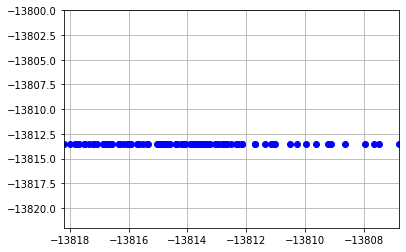

In [23]:
plt.plot(test_labels,prediction, 'o', color='blue')
plt.grid()
plt.xlim([min(test_labels), max(test_labels)])
#plt.ylim([min(prediction), max(prediction)])
plt.ylim([-13822,-13800])


In [40]:
print('layer 1')
print('weights')
print(net.network1.fc1.weight)
print('biases')
print(net.network1.fc1.bias)

print('layer 2')
print('weights')
print(net.network1.fc2.weight)
print('biases')
print(net.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.0166,  0.2766, -0.1227,  ...,  0.1807,  0.0396,  0.3947],
        [-0.0090,  0.0556, -0.1743,  ..., -0.0175, -0.0873,  0.2536],
        [-0.3145,  0.0177, -0.2611,  ...,  0.2352,  0.0127,  0.0297],
        ...,
        [ 0.1717, -0.2229,  0.1781,  ..., -0.0421,  0.1488, -0.1045],
        [ 0.2324, -0.0362,  0.1578,  ..., -0.1647,  0.1976, -0.3213],
        [-0.3657,  0.0091, -0.1728,  ...,  0.1632, -0.2348,  0.1775]],
       requires_grad=True)
biases
Parameter containing:
tensor([ 0.3150,  0.2278,  0.4670, -0.4401, -0.0635,  0.0421, -0.1552,  0.2608,
        -0.2144,  0.0010,  0.2058, -0.3406, -0.1346,  0.2246, -0.3257,  0.2257,
         0.4474, -0.4169,  0.3883, -0.1903,  0.5262,  0.3644, -0.2728, -0.3722,
         0.5378, -0.3577, -0.2477,  0.1436, -0.2633,  0.2176, -0.2883,  0.3818,
         0.0095,  0.2744, -0.4061, -0.3005,  0.1623, -0.2622, -0.3260,  0.4399],
       requires_grad=True)
layer 2
weights
Parameter containing:
tensor

In [25]:
print(heta)
print(Rs)
print(zeta)
print(lambdaa)

[0.43744681 0.03085106 0.33319149 0.11425532 0.47914894 0.0412766
 0.17680851 0.29148936 0.13510638 0.07255319 0.34361702 0.39574468
 0.12468085 0.20808511 0.28106383 0.06212766 0.32276596 0.02042553
 0.5        0.22893617 0.44787234 0.31234043 0.08297872 0.05170213
 0.15595745 0.48957447 0.09340426 0.14553191 0.18723404 0.21851064
 0.37489362 0.4687234  0.16638298 0.40617021 0.19765957 0.24978723
 0.35404255 0.45829787 0.01       0.2706383  0.41659574 0.38531915
 0.26021277 0.36446809 0.30191489 0.42702128 0.10382979 0.2393617 ]
[0.38297872 0.76595745 0.53191489 0.40425532 0.34042553 0.19148936
 0.59574468 0.44680851 0.65957447 0.72340426 0.36170213 0.85106383
 0.27659574 0.89361702 0.55319149 0.78723404 0.0212766  0.10638298
 1.         0.25531915 0.29787234 0.70212766 0.4893617  0.17021277
 0.9787234  0.80851064 0.57446809 0.12765957 0.68085106 0.06382979
 0.82978723 0.08510638 0.61702128 0.87234043 0.31914894 0.14893617
 0.23404255 0.74468085 0.91489362 0.63829787 0.93617021 0.4680

In [26]:
a = np.array([0.18723404, 0.17680851 ,0.32276596 ,0.2393617,  0.20808511, 0.34361702,
 0.21851064 ,0.31234043, 0.22893617, 0.07255319, 0.08297872, 0.19765957,
 0.24978723, 0.36446809, 0.10382979, 0.16638298, 0.37489362, 0.29148936,
 0.45829787, 0.28106383, 0.13510638 ,0.38531915 ,0.02042553 ,0.44787234,
 0.2706383 , 0.41659574, 0.09340426 ,0.03085106 ,0.4687234,  0.01,
 0.48957447, 0.35404255 ,0.42702128,0.47914894 ,0.5 ,       0.39574468,
 0.05170213 ,0.06212766 ,0.11425532, 0.30191489, 0.26021277, 0.0412766,
 0.15595745 ,0.12468085,0.33319149, 0.40617021 ,0.14553191, 0.43744681])

In [27]:
b = np.array([0.44680851 ,0.76595745, 0.74468085, 0.38297872, 0.57446809, 0.61702128,
 0.53191489, 0.59574468, 0.0212766,  0.19148936, 0.70212766, 0.25531915,
 0.36170213, 0.14893617 ,0.42553191, 0.72340426, 0.04255319, 0.68085106,
 0.87234043, 0.93617021, 1.,         0.40425532, 0.46808511, 0.91489362,
 0.34042553, 0.23404255, 0.63829787, 0.65957447, 0.10638298, 0.78723404,
 0.21276596, 0.55319149, 0.5106383,  0.08510638, 0.06382979, 0.27659574,
 0.,         0.95744681, 0.80851064 ,0.12765957, 0.17021277, 0.85106383,
 0.4893617,  0.82978723, 0.29787234, 0.89361702, 0.31914894, 0.9787234 ])

In [28]:
c = np.array([0.32978723, 0.21276596, 0.19148936, 0.25531915 ,0.4787234,  0.38297872,
 0.29787234 ,0.28723404 ,0.34042553, 0.40425532 ,0.20212766, 0.10638298,
 0.04255319 ,0.43617021, 0.30851064, 0.07446809 ,0.27659574 ,0.05319149,
 0.09574468 ,0.17021277, 0.46808511 ,0.0212766 , 0.13829787, 0.42553191,
 0.23404255 ,0.24468085 ,0.35106383, 0.4893617 , 0.45744681, 0.0106383,
 0.44680851 ,0.         ,0.26595745, 0.15957447 ,0.08510638 ,0.36170213,
 0.12765957 ,0.39361702 ,0.18085106, 0.03191489, 0.11702128 ,0.5,
 0.22340426 ,0.41489362 ,0.31914894 ,0.37234043, 0.06382979, 0.14893617])